# import package

In [335]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [336]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.feature_selection import SelectKBest, f_classif
import category_encoders as ce
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

# load dataset and understanding

In [337]:
data = pd.read_csv("movie_metadata.csv")

In [338]:
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [339]:
data.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

In [340]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4935 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5035 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

initial insights

color - do label encoder, if have missing value, use mode or domain knowledge 

director_name, actor_1_name, actor_2_name, actor_3_name - check unique value, if too many , can drop

actor_1_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes, director_facebook_likes - can use for analyzes trnds, fill missing value using median

num_critic_for_reviews, num_voted_users, gross, num_user_for_reviews - find correlation with imdb_score (i think is high related), find skewness, normalization, fill missing values using median

duration - find outliers, find correlation with imdb_score (i think no related), investigate outliers, fill missing values with median or mean

genres,plot_keywords - multiple genre need to seperate to different category, plot_keyword maybe need to drop

movie_tile - can drop if no related

movie_imdb_link - drop

cast_total_facebook_likes, movie_facebook_like - find relationship with actor_1_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes, gross, imdb_score, drop if highly related, else fill with median

facenumber_in_poster - find relationship with genres and imdb_score, use mode/median to fill missing value

language, country -  one hot encoder/ target encoding with smoothing, find relationship with imdb_score

budget - find skewness, find impact on gross and imdb_score, use median to fill missing value

title year - convert missing values using release data if no much missing value/ mode, find relationship with imdb_score

imdb_score - categorize

aspect_ratio, content rating - one hot/ target, check if can group or not, check if any outliers, maybe fill with mode


In [341]:
#remove redundant warnings
#https://github.com/mwaskom/seaborn/issues/3462
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

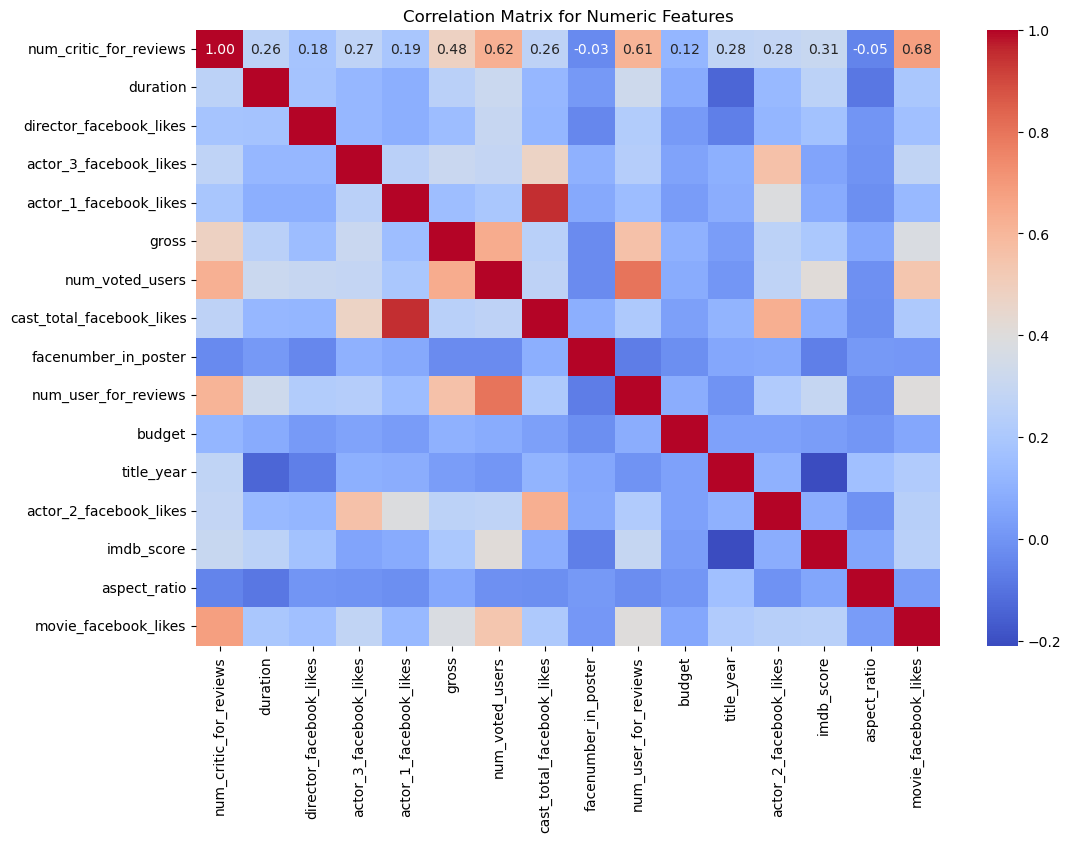

In [342]:
#see correlation between numeric data
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

In [343]:
data.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4935.000000,5020.000000,5035.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,687.058967,645.009761,6561.292552,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2814.402420,1665.041728,15021.990913,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.500000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,195.000000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [344]:
#find unique values for each object
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"{column}: {data[column].nunique()} unique values")

color: 2 unique values
director_name: 2398 unique values
actor_2_name: 3032 unique values
genres: 914 unique values
actor_1_name: 2097 unique values
movie_title: 4917 unique values
actor_3_name: 3521 unique values
plot_keywords: 4760 unique values
movie_imdb_link: 4919 unique values
language: 46 unique values
country: 65 unique values
content_rating: 18 unique values


In [345]:
#check duplicate row
data.duplicated().sum()

45

# data preprocessing and cleaning


## remove duplicate row

In [346]:
data = data.drop_duplicates()

## handle missing and unreasonable values

### handle color missing value

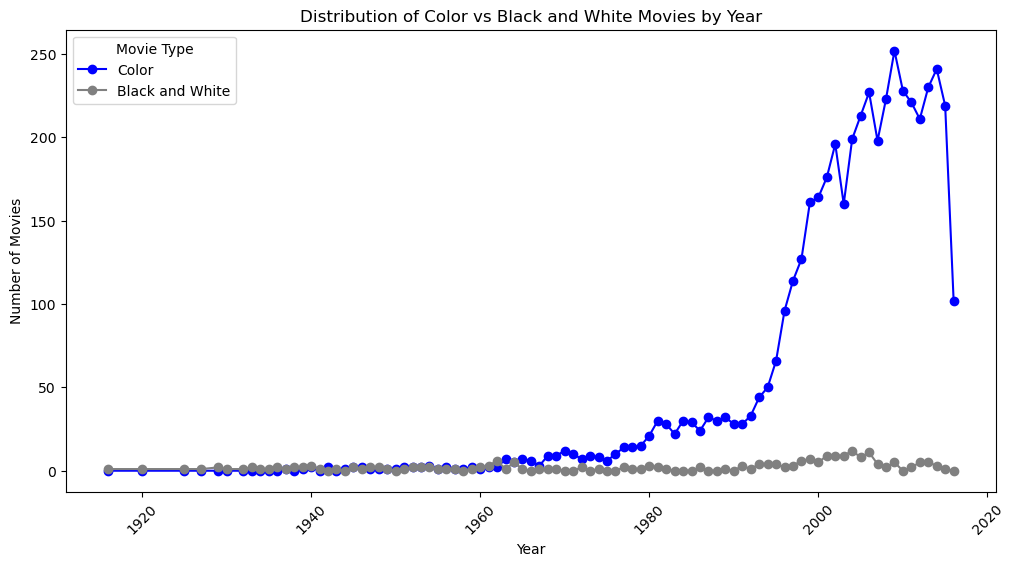

In [347]:
grouped_data = data.groupby(['title_year', 'color']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data['Color'], label='Color', color='blue', marker='o')
plt.plot(grouped_data.index, grouped_data[' Black and White'], label='Black and White', color='gray', marker='o')

plt.title('Distribution of Color vs Black and White Movies by Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.legend(title='Movie Type')

plt.show()

In [348]:
# Fill missing values in 'color' based on 'title_year'
data['color'] = data.apply(
    lambda row: ' Black and White' if pd.isnull(row['color']) and row['title_year'] < 1967 else
                ('Color' if pd.isnull(row['color']) else row['color']),
    axis=1
)

In [349]:
# encoding
data['color'] = data['color'].map({' Black and White': 0, 'Color': 1})

### handle actor and director facebook likes

In [350]:
#check if have facebook like with same name in other row
all_actors = pd.concat([
    data[['actor_1_name', 'actor_1_facebook_likes']].rename(columns={'actor_1_name': 'actor_name', 'actor_1_facebook_likes': 'facebook_likes'}),
    data[['actor_2_name', 'actor_2_facebook_likes']].rename(columns={'actor_2_name': 'actor_name', 'actor_2_facebook_likes': 'facebook_likes'}),
    data[['actor_3_name', 'actor_3_facebook_likes']].rename(columns={'actor_3_name': 'actor_name', 'actor_3_facebook_likes': 'facebook_likes'})
])

actor_medians = all_actors.groupby('actor_name')['facebook_likes'].median()

for col_name, likes_col in [('actor_1_name', 'actor_1_facebook_likes'), 
                            ('actor_2_name', 'actor_2_facebook_likes'), 
                            ('actor_3_name', 'actor_3_facebook_likes')]:
    data[likes_col] = data.apply(
        lambda row: actor_medians[row[col_name]] if pd.isnull(row[likes_col]) and row[col_name] in actor_medians else row[likes_col],
        axis=1
    )

data['director_facebook_likes'] = data.groupby('director_name')['director_facebook_likes'].transform(
    lambda x: x.fillna(x.median())
)

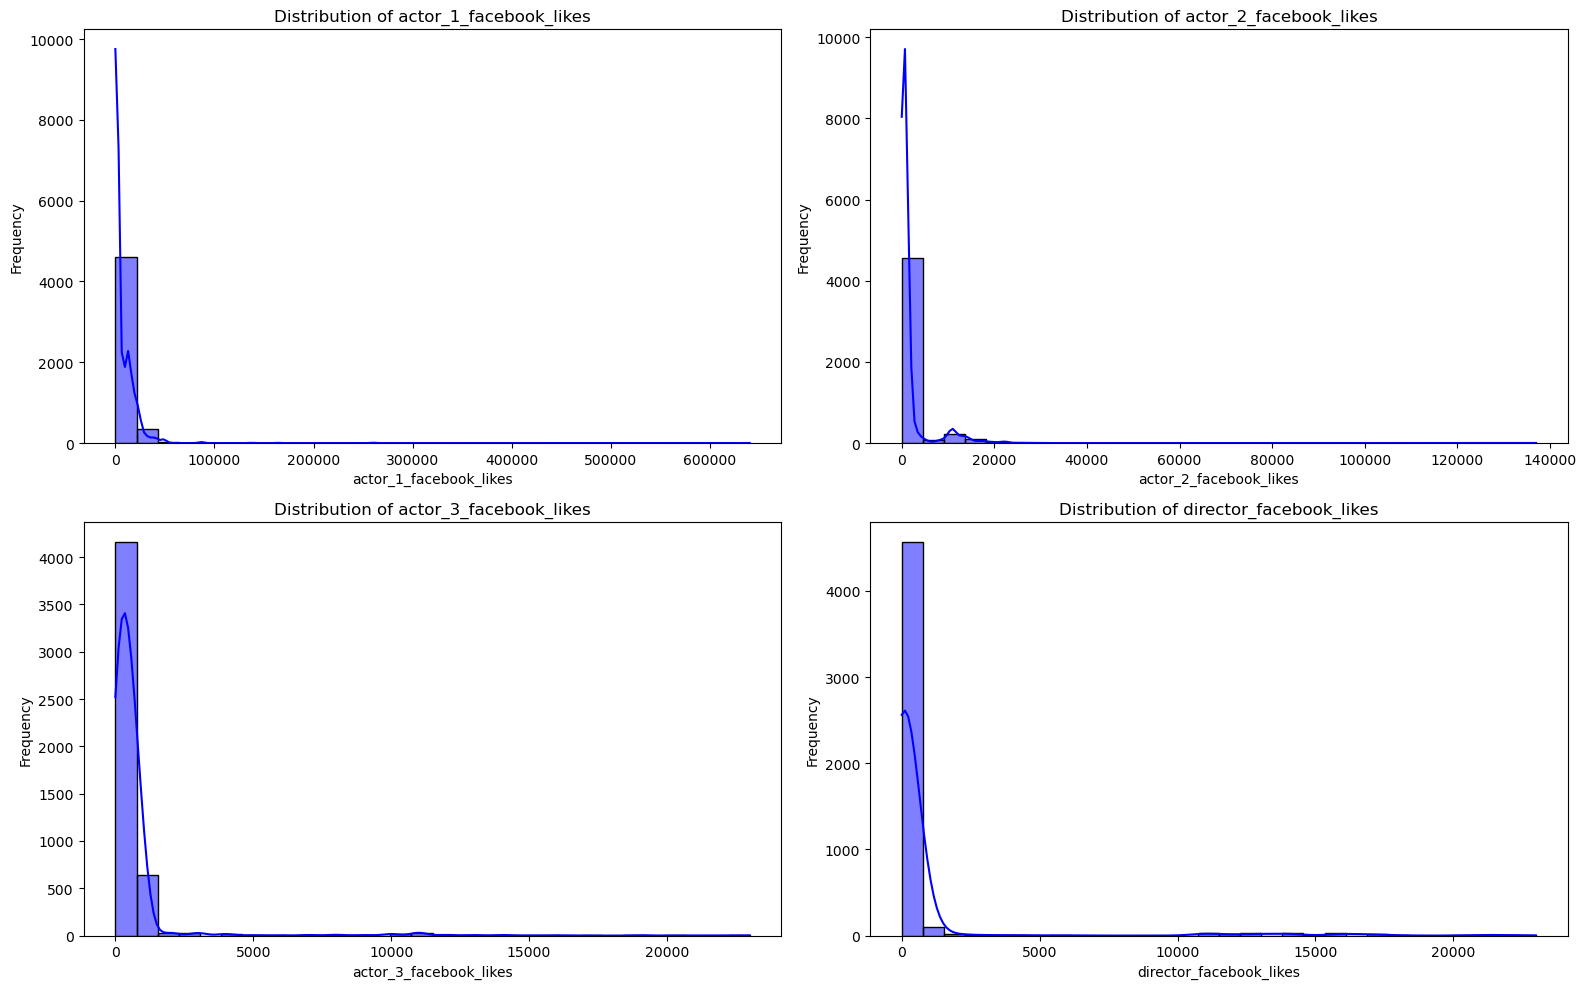

In [351]:
#check skewness
features = ['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'director_facebook_likes']

plt.figure(figsize=(16, 10))

for feature in features:
    if np.isinf(data[feature]).any():
        print(f"Infinite values found in {feature}")
        
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [352]:
#the data is highly skewed, so use median for all
data['actor_3_facebook_likes'].fillna(data['actor_3_facebook_likes'].median(), inplace=True)
data['actor_1_facebook_likes'].fillna(data['actor_1_facebook_likes'].median(), inplace=True)
data['actor_2_facebook_likes'].fillna(data['actor_2_facebook_likes'].median(), inplace=True)
data['director_facebook_likes'].fillna(data['director_facebook_likes'].median(), inplace=True)

### handle duration

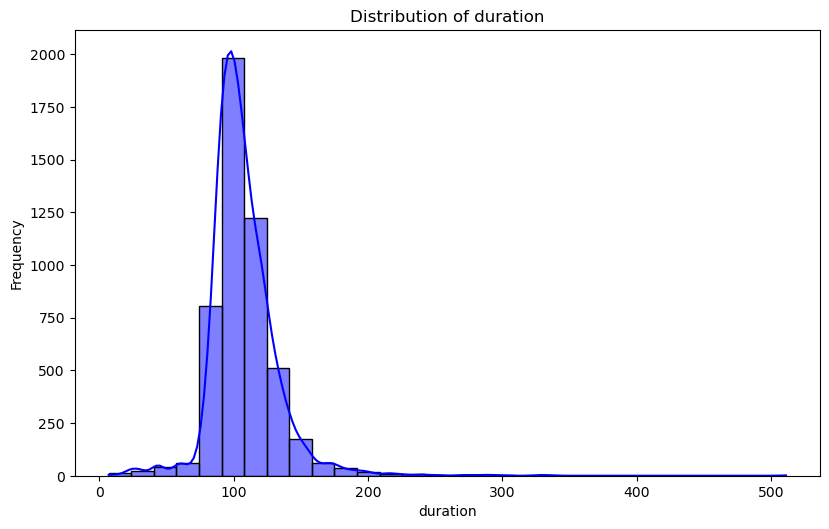

In [353]:
features = ['duration']

plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [354]:
data['duration'].fillna(data['duration'].median(), inplace=True)

### handle num_critic_for_reviews 

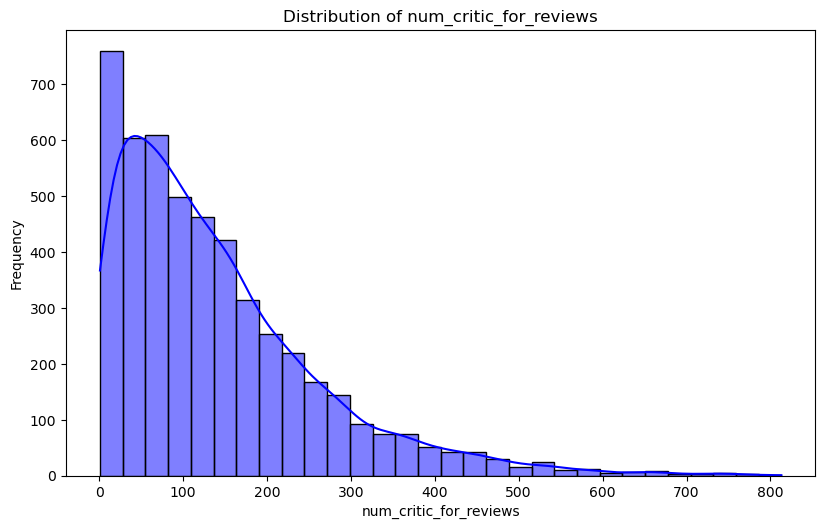

In [355]:
features = ['num_critic_for_reviews']

plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [356]:
data['num_critic_for_reviews'].fillna(data['num_critic_for_reviews'].median(), inplace=True)

### handle num_user_for_reviews

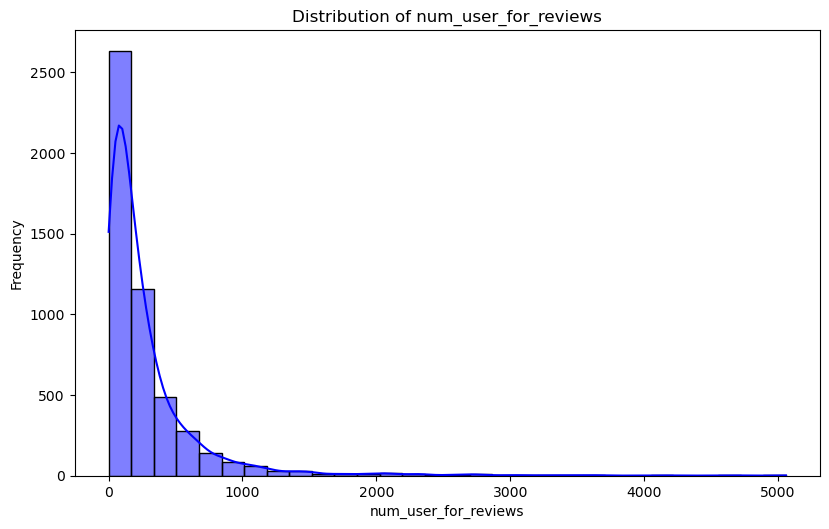

In [357]:
features = ['num_user_for_reviews']

plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [358]:
data['num_user_for_reviews'].fillna(data['num_user_for_reviews'].median(), inplace=True)

### handle gross

In [359]:
#use linear regression, first check the correlation with other features
correlation = data[['gross', 'num_user_for_reviews']].corr()
print(correlation)

correlation = data[['gross', 'num_voted_users']].corr()
print(correlation)

correlation = data[['gross', 'num_critic_for_reviews']].corr()
print(correlation)

                         gross  num_user_for_reviews
gross                 1.000000              0.561028
num_user_for_reviews  0.561028              1.000000
                    gross  num_voted_users
gross            1.000000         0.635271
num_voted_users  0.635271         1.000000
                           gross  num_critic_for_reviews
gross                   1.000000                0.477695
num_critic_for_reviews  0.477695                1.000000


In [360]:
#https://stats.stackexchange.com/questions/196628/handling-many-missing-values-within-a-regressio
from sklearn.linear_model import LinearRegression
features = ['num_voted_users', 'num_user_for_reviews','imdb_score']
df_notnull = data[data['gross'].notnull()]
df_null = data[data['gross'].isnull()]

X = df_notnull[features]
y = df_notnull['gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
print("Model R^2:", model.score(X_test, y_test)) 

# Predict missing values
data.loc[data['gross'].isnull(), 'gross'] = model.predict(df_null[features])

Model R^2: 0.4394800308151683


### handle facenumber in poster

In [361]:
data['facenumber_in_poster'].fillna(data['facenumber_in_poster'].median(), inplace=True)

### handle budget

In [362]:
#check correlation with target to decide use linear regression or not
correlation = data[['imdb_score', 'budget']].corr()
print(correlation)

correlation = data[['imdb_score', 'title_year']].corr()
print(correlation)

            imdb_score    budget
imdb_score    1.000000  0.031061
budget        0.031061  1.000000
            imdb_score  title_year
imdb_score    1.000000   -0.207591
title_year   -0.207591    1.000000


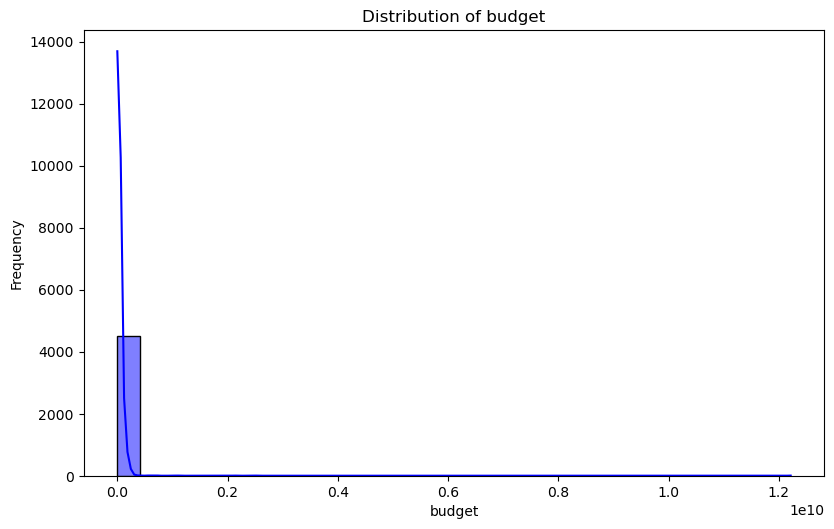

In [363]:
features = ['budget']

plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [364]:
#since not important feature, direct use median
data['budget'] = data['budget'].fillna(data['budget'].median())

### handle title year

In [365]:
# Check rows with missing 'title_year'
missing_title_year = data[data['title_year'].isnull()]
missing_title_year.describe(include='all')

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,107.000000,4,107.000000,107.000000,107.000000,107.000000,104,107.000000,1.070000e+02,107,...,107.000000,104,103,65,1.070000e+02,0.0,107.000000,107.000000,85.000000,107.000000
unique,NaN,4,NaN,NaN,NaN,NaN,103,NaN,NaN,67,...,NaN,7,11,7,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Doug Walker,NaN,NaN,NaN,NaN,Olaf Lubaszenko,NaN,NaN,Comedy,...,NaN,English,USA,TV-14,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,2,NaN,NaN,9,...,NaN,96,73,27,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.971963,NaN,31.028037,63.065421,49.102804,335.149533,NaN,1392.504673,1.770642e+07,NaN,...,94.439252,NaN,NaN,NaN,1.911402e+07,NaN,474.785047,7.564486,7.201529,4424.457944
std,0.165856,NaN,33.831842,66.983139,10.751862,245.216878,NaN,3604.244836,1.302461e+07,NaN,...,103.370937,NaN,NaN,NaN,4.279734e+06,NaN,387.422908,1.037254,6.911459,11363.984074
min,0.000000,NaN,1.000000,7.000000,0.000000,0.000000,NaN,0.000000,-1.692614e+06,NaN,...,1.000000,NaN,NaN,NaN,1.400000e+06,NaN,0.000000,2.900000,1.330000,0.000000
25%,1.000000,NaN,8.000000,30.000000,49.000000,141.500000,NaN,419.000000,9.444412e+06,NaN,...,29.500000,NaN,NaN,NaN,2.000000e+07,NaN,175.000000,7.300000,1.330000,0.000000
50%,1.000000,NaN,17.000000,45.000000,49.000000,319.000000,NaN,770.000000,1.455157e+07,NaN,...,57.000000,NaN,NaN,NaN,2.000000e+07,NaN,476.000000,7.600000,1.850000,141.000000
75%,1.000000,NaN,46.500000,60.000000,49.000000,487.500000,NaN,971.000000,2.073521e+07,NaN,...,133.500000,NaN,NaN,NaN,2.000000e+07,NaN,699.500000,8.200000,16.000000,958.500000


In [366]:
#since the title year quite important, so use linear regression
features = ['color', 'num_critic_for_reviews','imdb_score']

df_notnull = data[data['title_year'].notnull()]
df_null = data[data['title_year'].isnull()]
X = df_notnull[features]
y = df_notnull['title_year']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
print("Model R^2:", model.score(X_test, y_test)) 

# Predict missing values
data.loc[data['title_year'].isnull(), 'title_year'] = model.predict(df_null[features])

Model R^2: 0.20931600639932535


### handle country and language

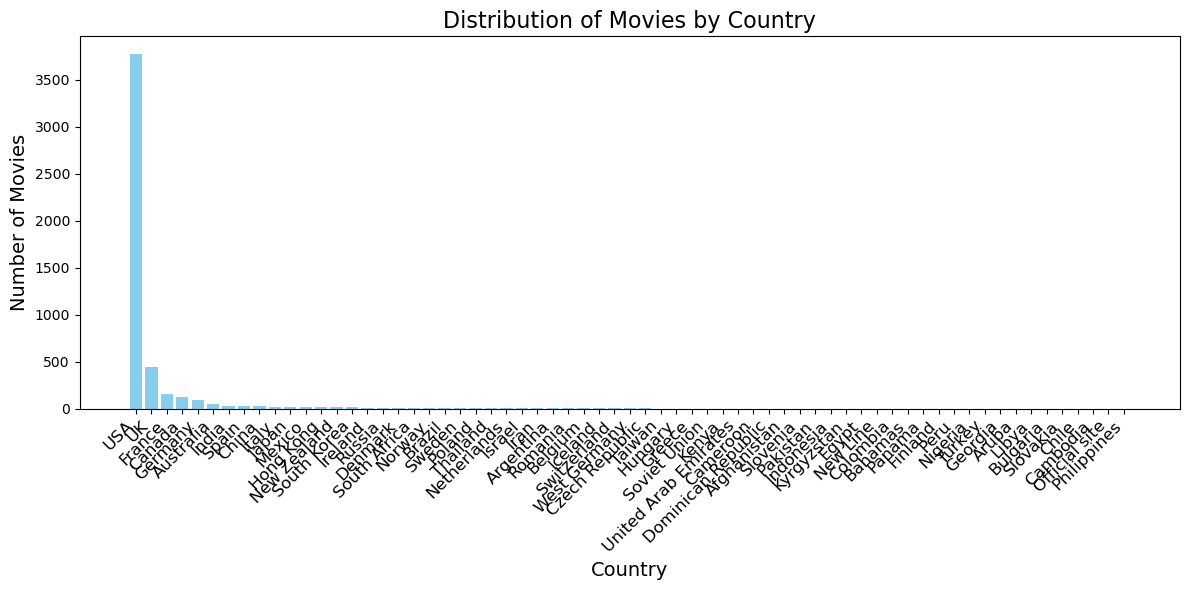

In [367]:
country_counts = data['country'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(country_counts.index, country_counts.values, color='skyblue')
plt.title('Distribution of Movies by Country', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate country names for better readability
plt.tight_layout()
plt.show()

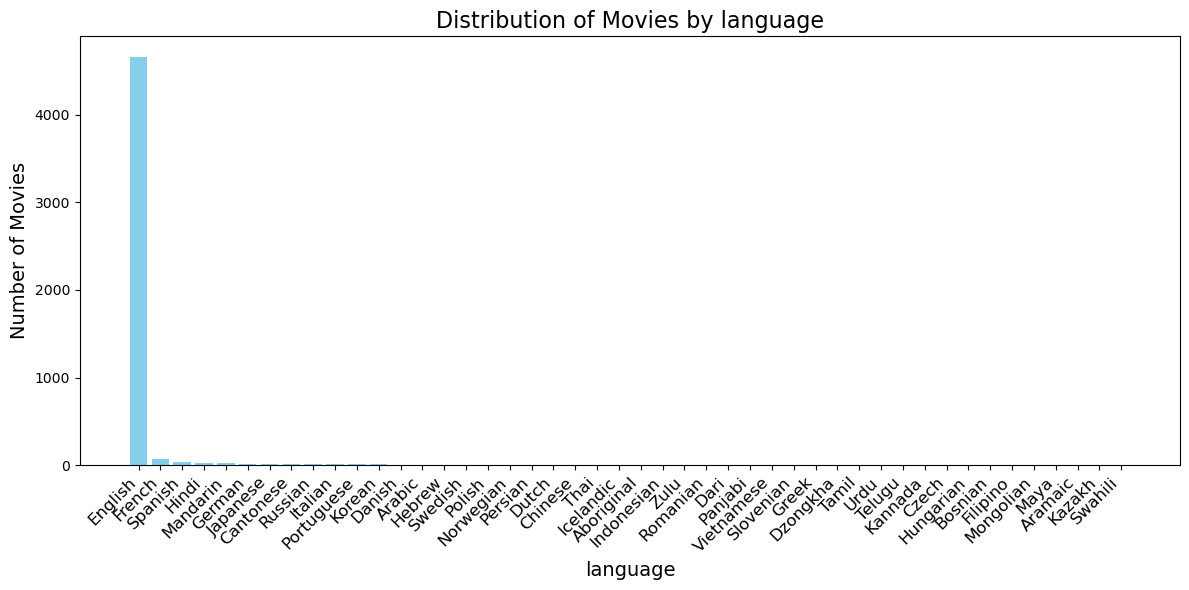

In [368]:
country_counts = data['language'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(country_counts.index, country_counts.values, color='skyblue')
plt.title('Distribution of Movies by language', fontsize=16)
plt.xlabel('language', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate country names for better readability
plt.tight_layout()
plt.show()

In [369]:
# handle country
data['country'].fillna(data['country'].mode()[0], inplace=True)

# handle language
data['language'].fillna(data['language'].mode()[0], inplace=True)


### handle aspect ratio

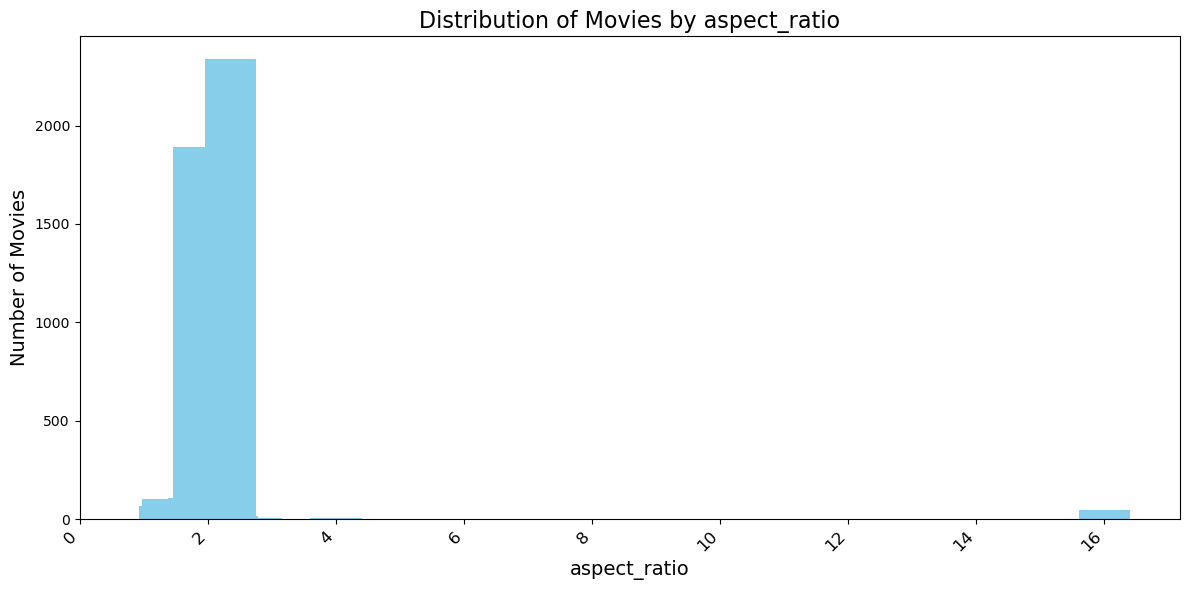

In [370]:
country_counts = data['aspect_ratio'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(country_counts.index, country_counts.values, color='skyblue')
plt.title('Distribution of Movies by aspect_ratio', fontsize=16)
plt.xlabel('aspect_ratio', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate country names for better readability
plt.tight_layout()
plt.show()

In [371]:
data['aspect_ratio'].unique()

array([ 1.78,  2.35,   nan,  1.85,  2.  ,  2.2 ,  2.39,  2.24,  1.33,
        4.  ,  1.66,  1.5 , 16.  ,  1.77,  2.4 ,  1.37,  2.76,  1.18,
        1.44,  2.55,  1.2 ,  1.75,  1.89])

https://borisfx.com/blog/what-is-aspect-ratio-common-aspect-ratios/

movie common aspect ratio

1.85, 1.77, 2.4, 1.78,  2.76,  1.33, 1.37, 2.39, - common

2.35,  2. , 2.2 ,  1.66, - common

2.24, 1.5, 1.75, 1.89 - rare

1.44,  2.55,  1.2 - unreasonable

1.18,16, 4  -unreasonable 

In [372]:
unusual_aspect_ratios = [1.18, 16, 4, 1.44, 2.55, 1.2]

# Filter the dataset for these aspect ratios
unusual_movies = data[data['aspect_ratio'].isin(unusual_aspect_ratios)]

# Display the movie titles and their aspect ratios
print(unusual_movies[['movie_title', 'aspect_ratio']])


                                     movie_title  aspect_ratio
260                      The A-Team                       4.00
459                       Daredevil                      16.00
479                       Bewitched                       4.00
537                     Constantine                      16.00
593                   Sleepy Hollow                      16.00
645               Last Man Standing                      16.00
833                Anger Management                      16.00
1007                        Twisted                      16.00
1035                      Outlander                      16.00
1133                   The Returned                      16.00
1175                  McHale's Navy                       4.00
1404                      Rush Hour                      16.00
1499                         Luther                      16.00
1659                     The Family                      16.00
1710                        Trapped                    

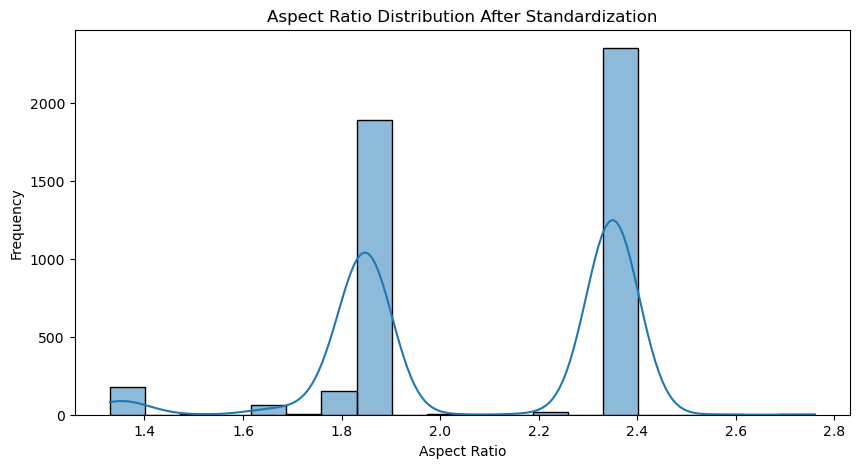

In [373]:
# change specific aspect ratios to normal
data['aspect_ratio'] = data['aspect_ratio'].replace({16: 1.78, 4: 1.33, 1.18:1.33, 1.2:1.33})

# see the distribution of the aspect ratio again
plt.figure(figsize=(10, 5))
sns.histplot(data['aspect_ratio'], bins=20, kde=True)
plt.title("Aspect Ratio Distribution After Standardization")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.show()

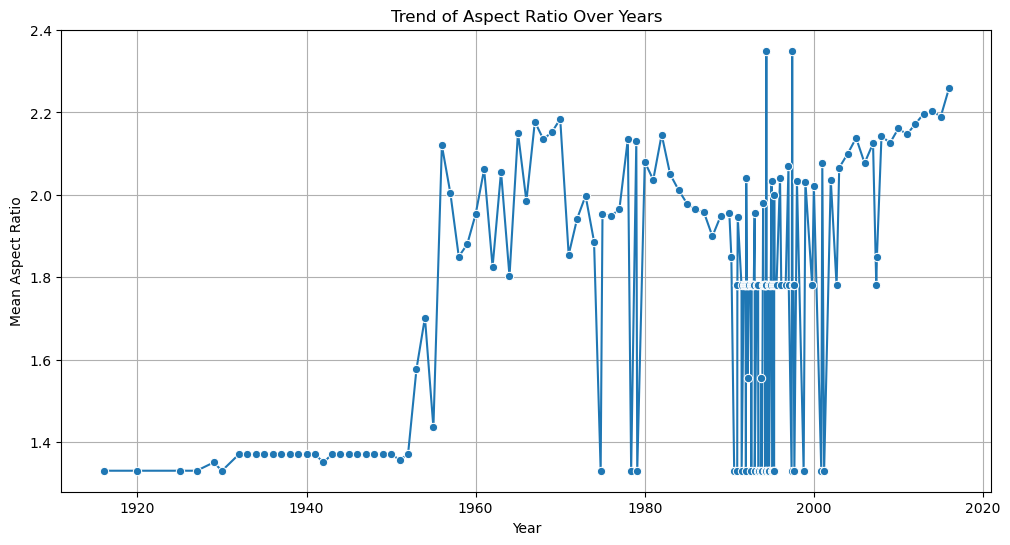

In [374]:
#trends of the aspect ratio
filtered_data = data.dropna(subset=['aspect_ratio', 'title_year'])
filtered_data = filtered_data[filtered_data['aspect_ratio'] <= 2.76] 

yearly_aspect_ratio = filtered_data.groupby('title_year')['aspect_ratio'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_aspect_ratio.index, y=yearly_aspect_ratio.values, marker="o")
plt.title("Trend of Aspect Ratio Over Years")
plt.xlabel("Year")
plt.ylabel("Mean Aspect Ratio")
plt.grid(True)
plt.show()

In [375]:
#https://www.filmeditingpro.com/a-history-of-aspect-ratio-in-film/
#since the trends same as the information described by the website, so fill the missing value according the website
def fill_aspect_ratio(row):
    if pd.isnull(row['aspect_ratio']):
        if row['title_year'] < 1958:
            return 1.33  
        elif row['title_year'] < 1990:
            return 1.85
        elif row['title_year'] < 2004:
            return 1.78
        else:
            return 2.35 
    return row['aspect_ratio']

data['aspect_ratio'] = data.apply(fill_aspect_ratio, axis=1)

### handle content rating

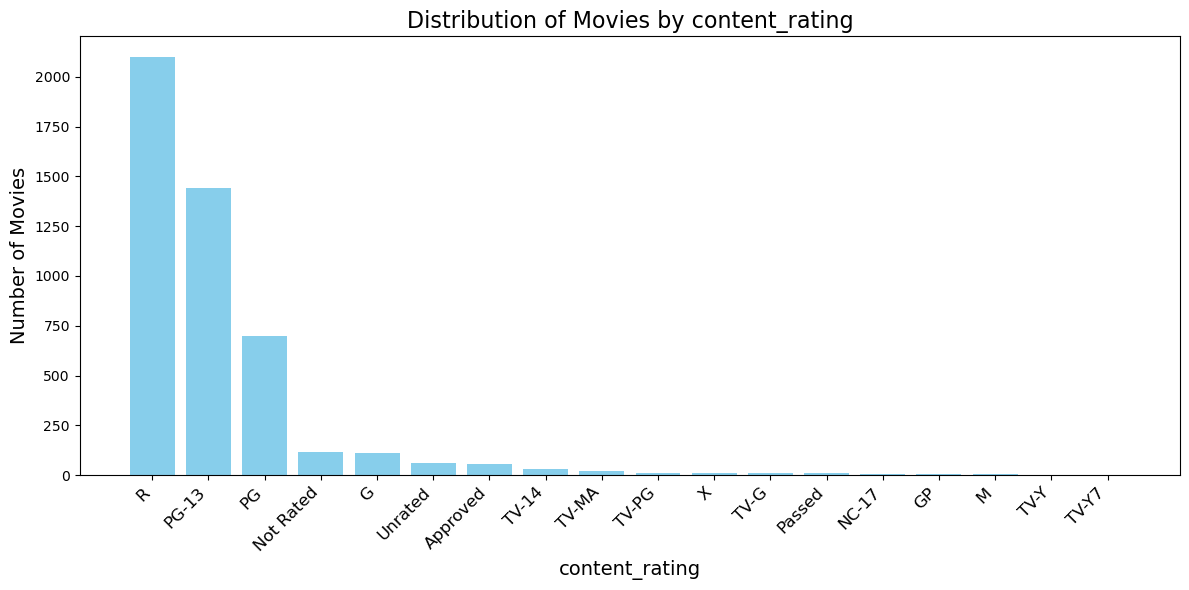

In [376]:
country_counts = data['content_rating'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(country_counts.index, country_counts.values, color='skyblue')
plt.title('Distribution of Movies by content_rating', fontsize=16)
plt.xlabel('content_rating', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate country names for better readability
plt.tight_layout()
plt.show()

In [377]:
data['content_rating'].unique()

array(['PG-13', nan, 'PG', 'G', 'R', 'TV-14', 'TV-PG', 'TV-MA', 'TV-G',
       'Not Rated', 'Unrated', 'Approved', 'TV-Y', 'NC-17', 'X', 'TV-Y7',
       'GP', 'Passed', 'M'], dtype=object)

In [378]:
#https://atlascinemas.net/ratings.html
#https://en.wikipedia.org/wiki/Television_content_rating_system
#some values are almost same but just different name, so can group together
def simplify_rating(rating):
    if rating in ['Not Rated', 'Unrated']:
        return 'Not Rated'
    elif rating in ['G', 'TV-G', 'GP', 'Passed','Approved']:
        return 'General'
    elif rating in ['PG', 'TV-PG']:
        return 'Parental Guidance'
    elif rating in ['PG-13', 'TV-14']:
        return 'Teen'
    elif pd.isna(rating) or rating in ['R', 'TV-MA', 'NC-17', 'X','M']:
        return 'Adult'
    elif rating in ['TV-Y', 'TV-Y7']:
        return 'Children'
    else:
        return rating  

data['content_rating'] = data['content_rating'].apply(simplify_rating)


In [379]:
data['content_rating'].unique()

array(['Teen', 'Adult', 'Parental Guidance', 'General', 'Not Rated',
       'Children'], dtype=object)

### handle genres

In [380]:
# Split genres into a list and flatten 
all_genres = data['genres'].dropna().str.split('|').explode().unique()

print(all_genres)

['Action' 'Adventure' 'Fantasy' 'Sci-Fi' 'Thriller' 'Documentary'
 'Romance' 'Animation' 'Comedy' 'Family' 'Musical' 'Mystery' 'Western'
 'Drama' 'History' 'Sport' 'Crime' 'Horror' 'War' 'Biography' 'Music'
 'Game-Show' 'Reality-TV' 'News' 'Short' 'Film-Noir']


In [381]:
#mean/ target encoding
# https://medium.com/@pingsubhak/how-to-handle-categorical-features-50e68c9f416a

import category_encoders as ce

data['genres_split'] = data['genres'].str.split('|')

exploded_data = data.explode('genres_split')

exploded_data.reset_index(drop=True, inplace=True)

target_encoder = ce.TargetEncoder(smoothing=1.0)

target_encoder.fit(exploded_data['genres_split'], exploded_data['imdb_score'])

exploded_data['encoded_genre'] = target_encoder.transform(exploded_data['genres_split'])

data['genres'] = exploded_data.groupby(exploded_data.index)['encoded_genre'].transform('mean')

data.drop(columns=['genres_split'], inplace=True)

### handle plot_keywords

In [382]:
# too many unique values so drop directly
data.drop(columns=['plot_keywords'], inplace=True)

In [383]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4998 entries, 0 to 5042
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4998 non-null   int64  
 1   director_name              4895 non-null   object 
 2   num_critic_for_reviews     4998 non-null   float64
 3   duration                   4998 non-null   float64
 4   director_facebook_likes    4998 non-null   float64
 5   actor_3_facebook_likes     4998 non-null   float64
 6   actor_2_name               4985 non-null   object 
 7   actor_1_facebook_likes     4998 non-null   float64
 8   gross                      4998 non-null   float64
 9   genres                     4998 non-null   float64
 10  actor_1_name               4991 non-null   object 
 11  movie_title                4998 non-null   object 
 12  num_voted_users            4998 non-null   int64  
 13  cast_total_facebook_likes  4998 non-null   int64  
 1

 ## encoding categorical variables

In [384]:
target_encoder = ce.TargetEncoder(smoothing=1.0)
data['language'] = target_encoder.fit_transform(data['language'], data['imdb_score'])

In [385]:
target_encoder = ce.TargetEncoder(smoothing=1.0)
data['country'] = target_encoder.fit_transform(data['country'], data['imdb_score'])

In [386]:
target_encoder = ce.TargetEncoder(smoothing=1.0)
data['content_rating'] = target_encoder.fit_transform(data['content_rating'], data['imdb_score'])

## remove low importance columns

In [387]:
#handle director_name, actor_2_name, actor_1_name, actor_3_name, movie_title, movie_imdb_link
#too many unique values, directly drop
data.drop(columns=['movie_title','movie_imdb_link'], inplace=True)
data.drop(columns=['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name'], inplace=True)

## investigate current dataset

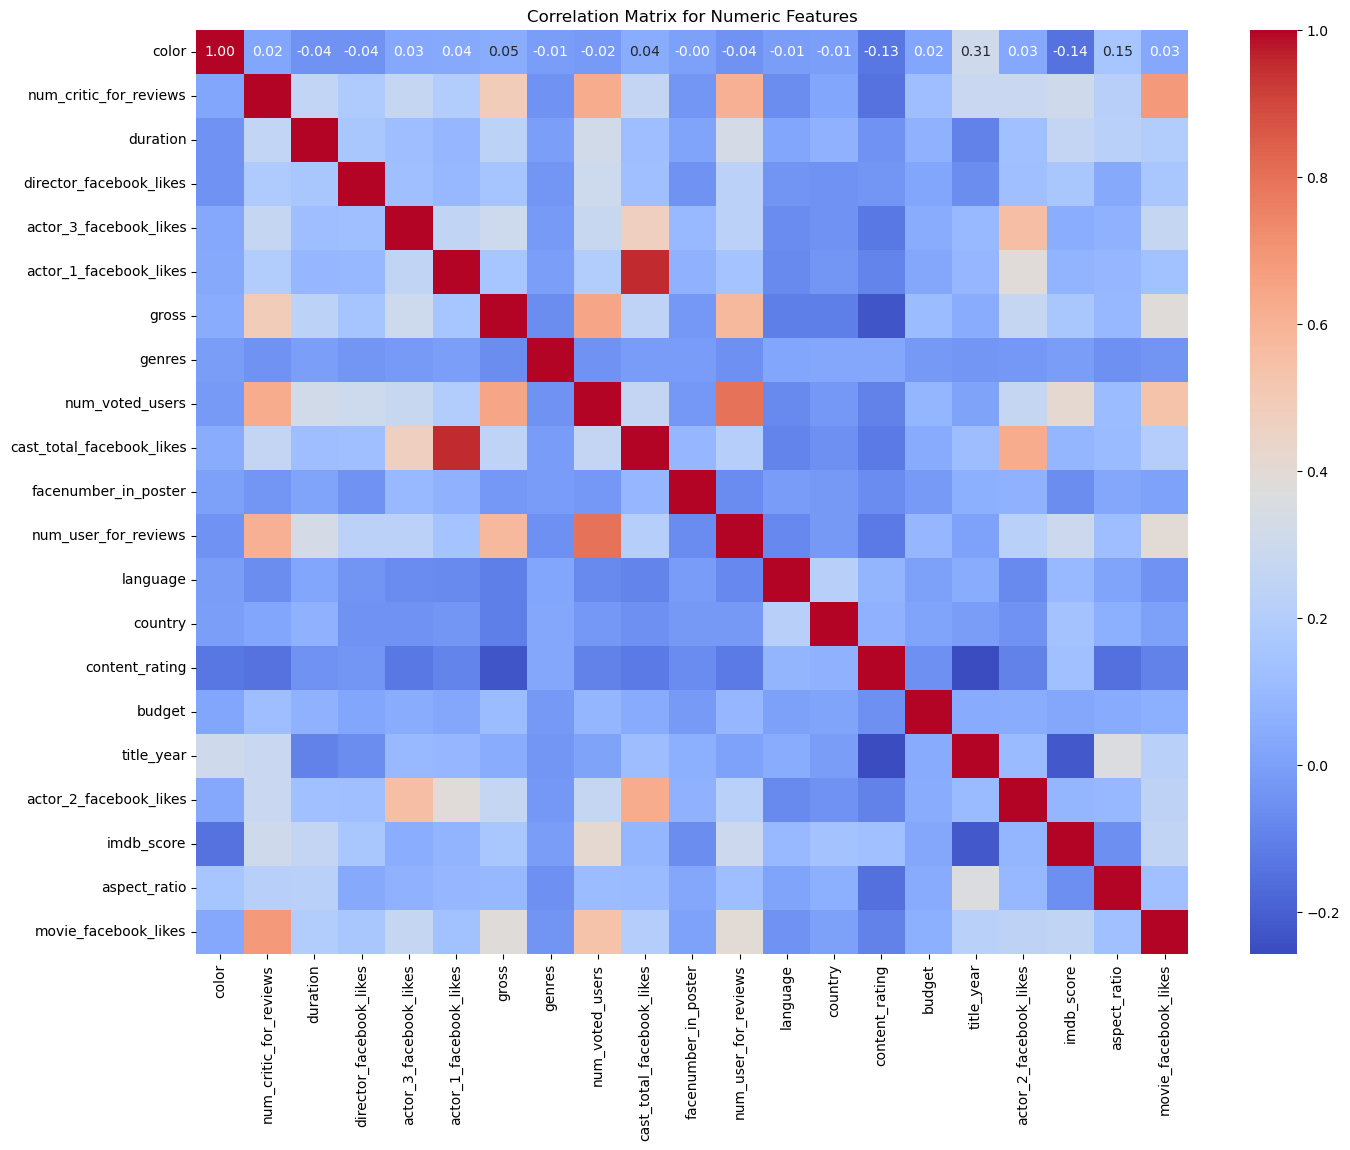

In [388]:
#see the correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = data.corr()

plt.figure(figsize=(16, 12)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10}, cbar=True)

plt.title('Correlation Matrix for Numeric Features')

# Show the plot
plt.show()

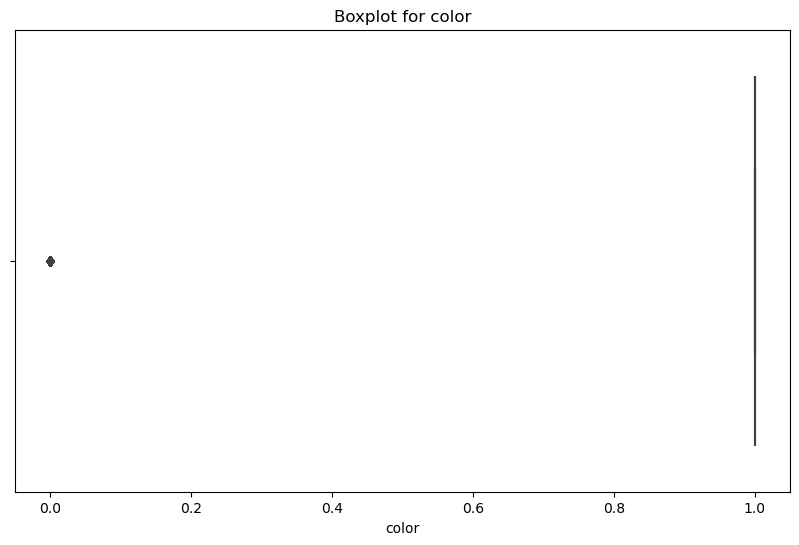

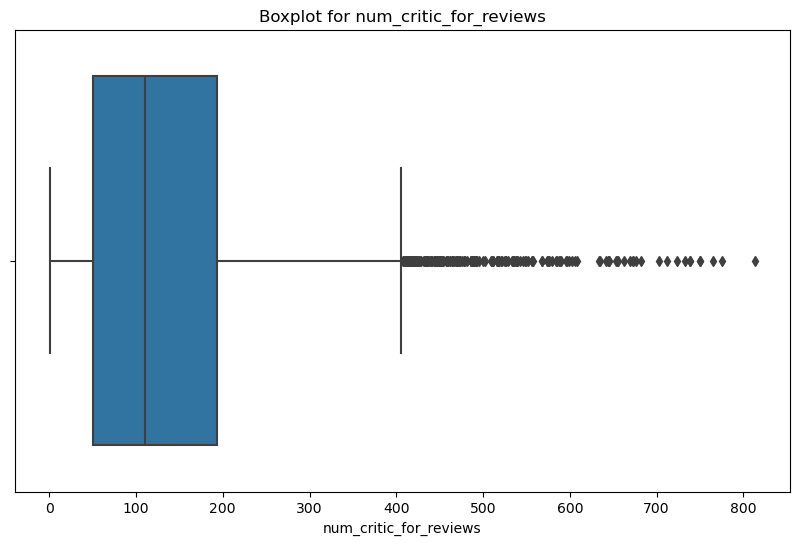

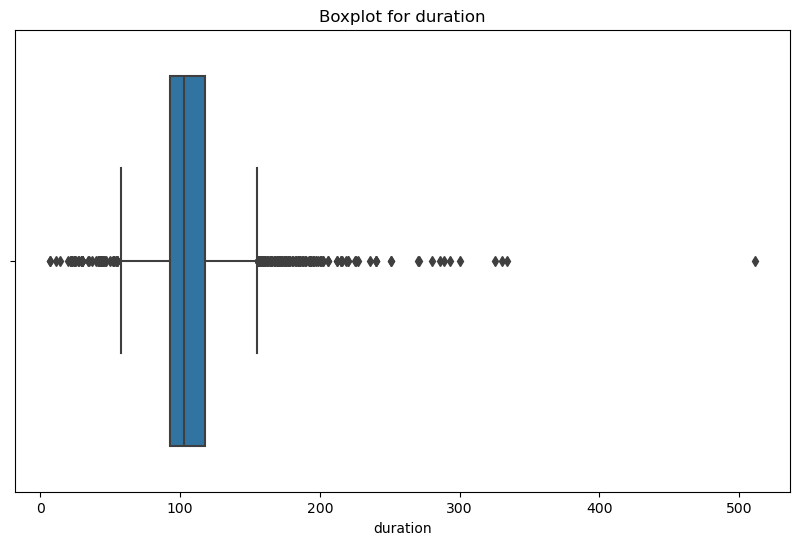

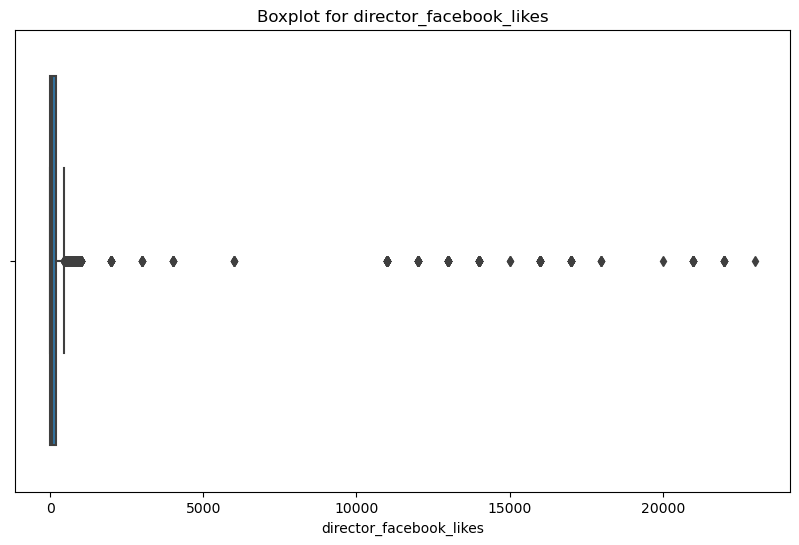

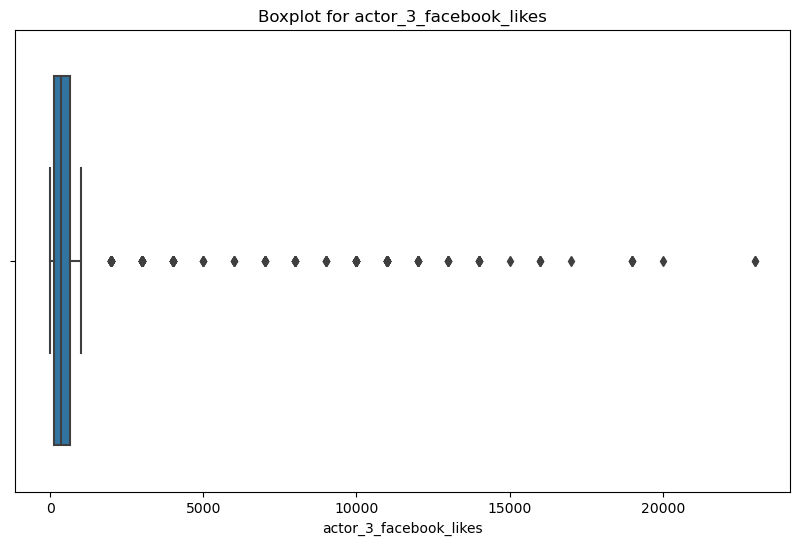

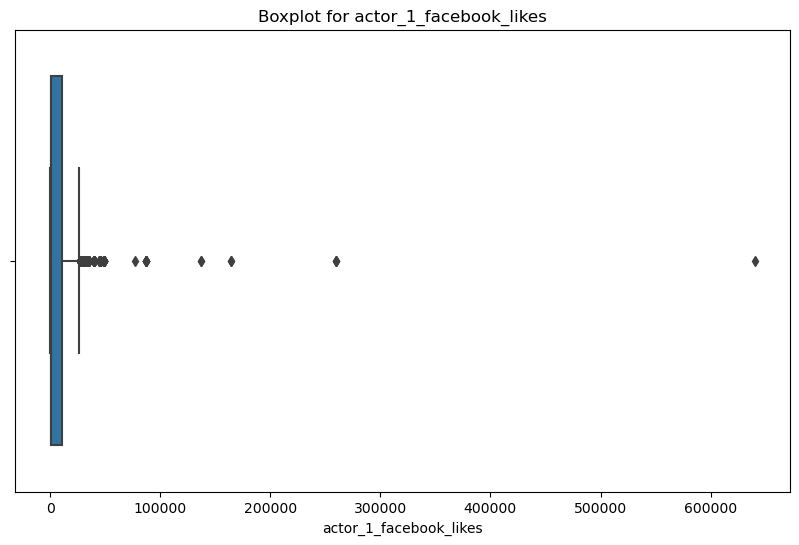

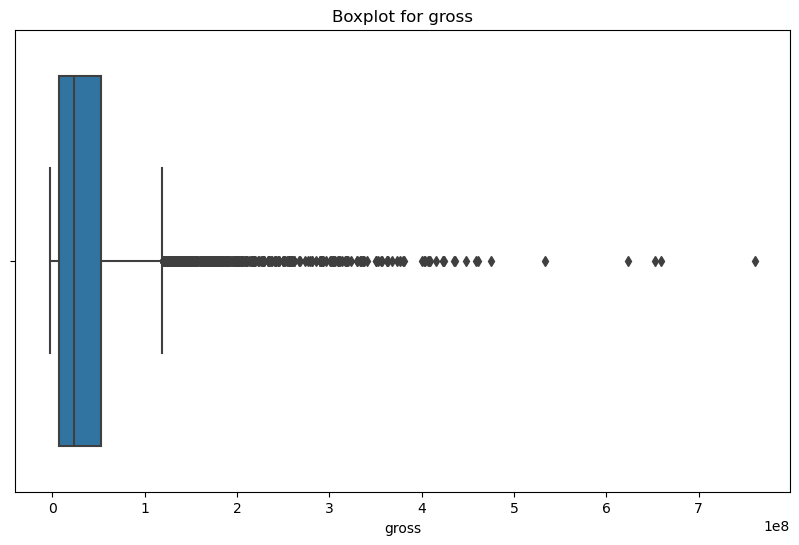

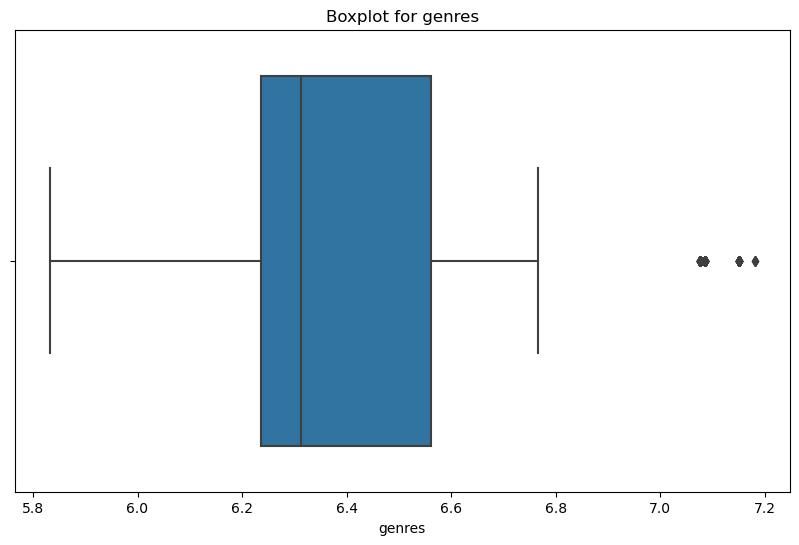

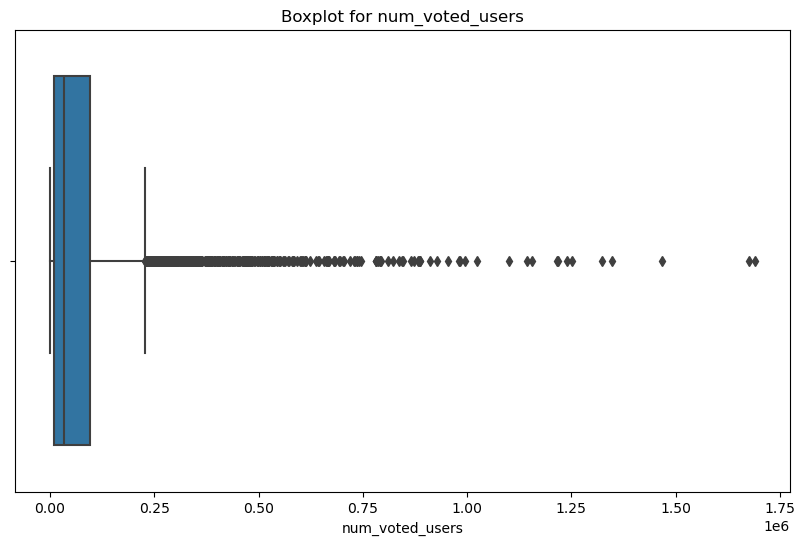

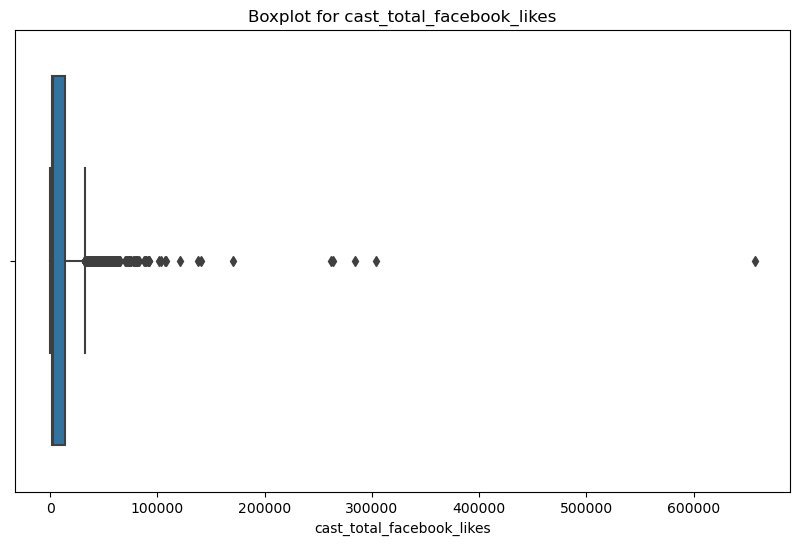

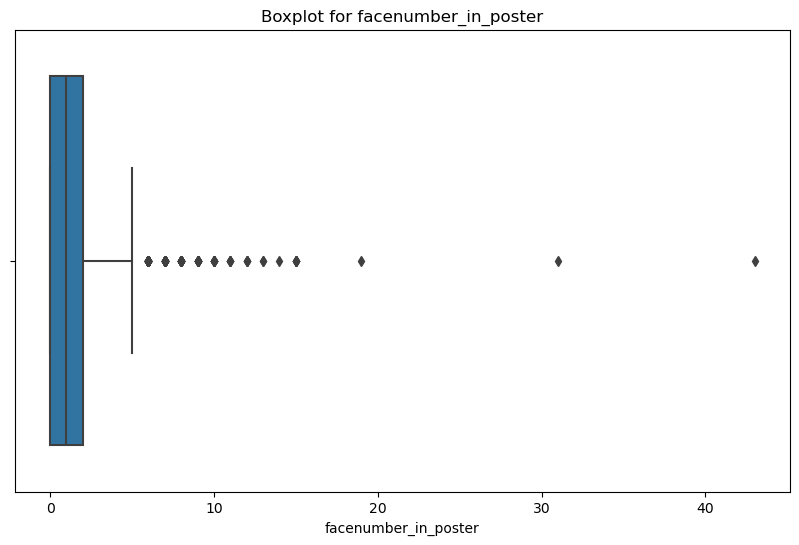

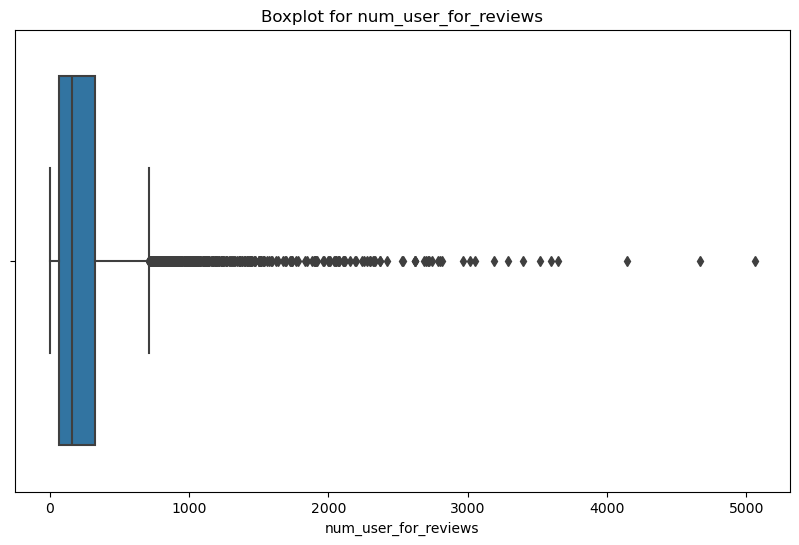

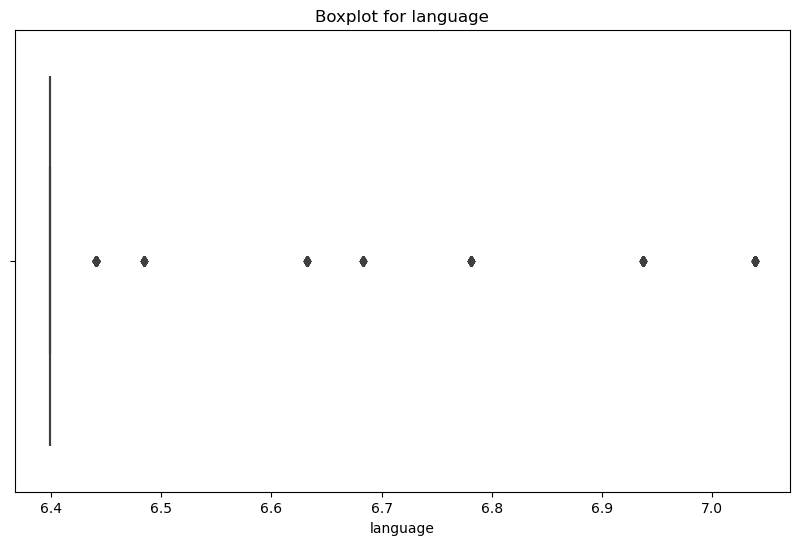

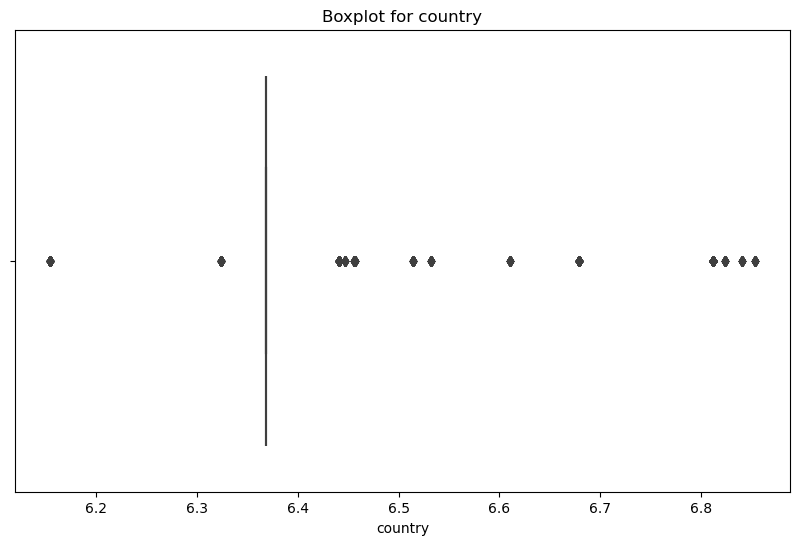

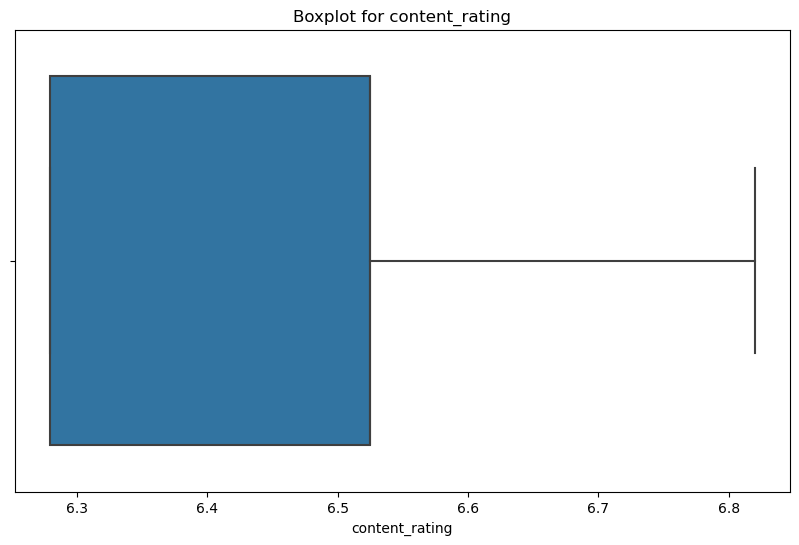

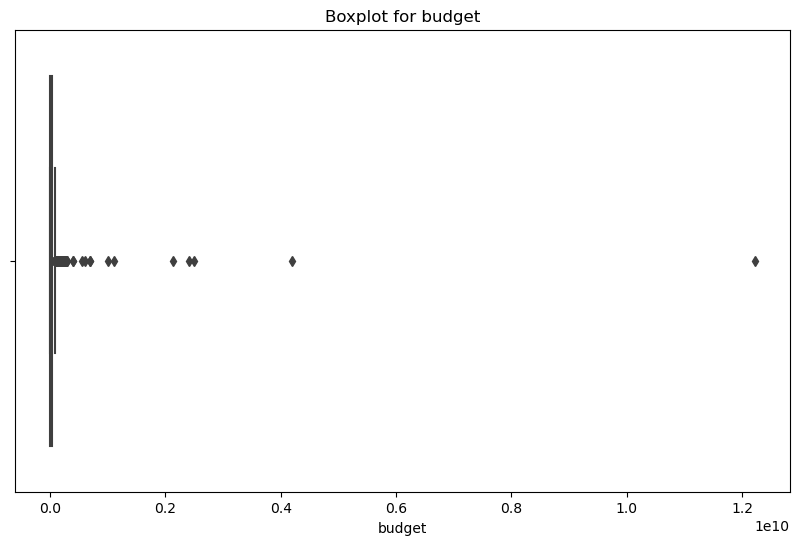

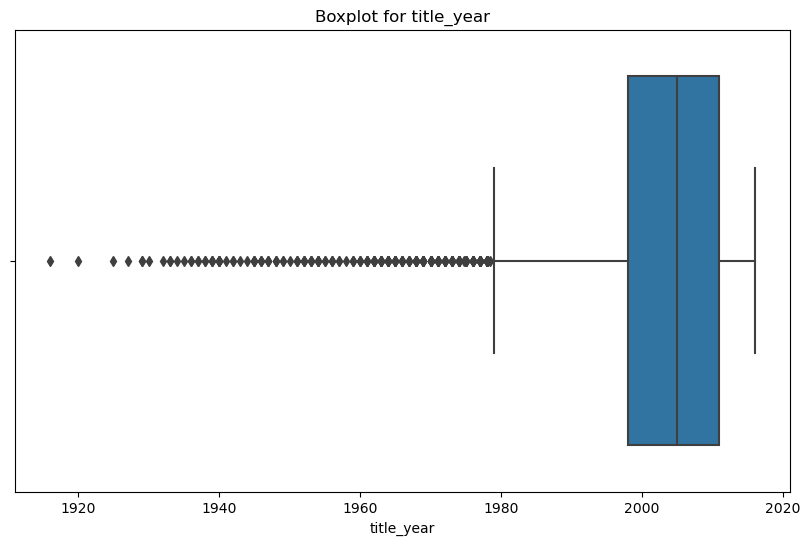

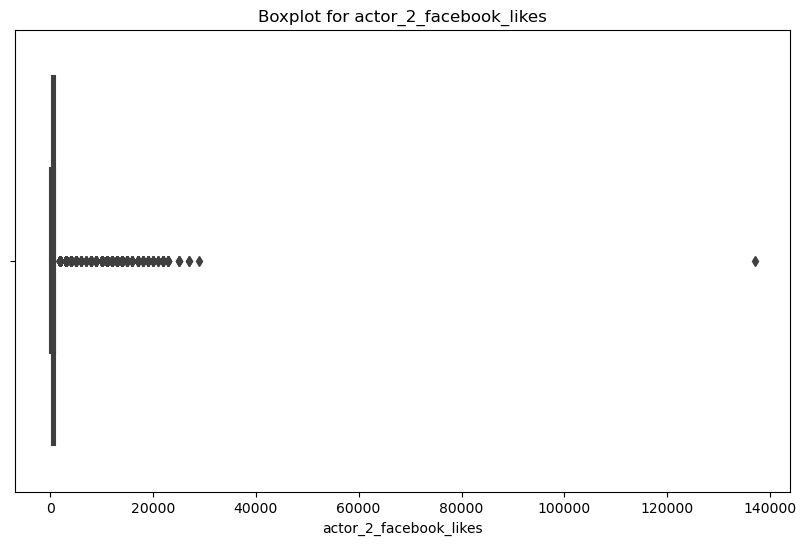

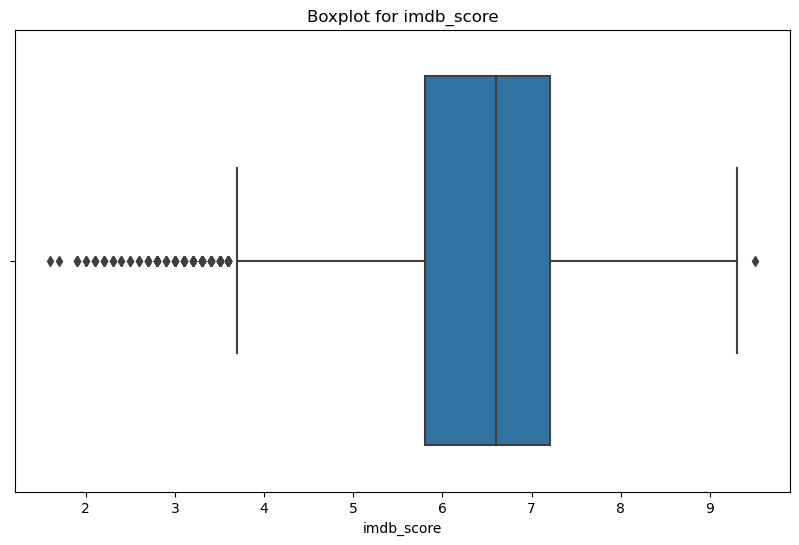

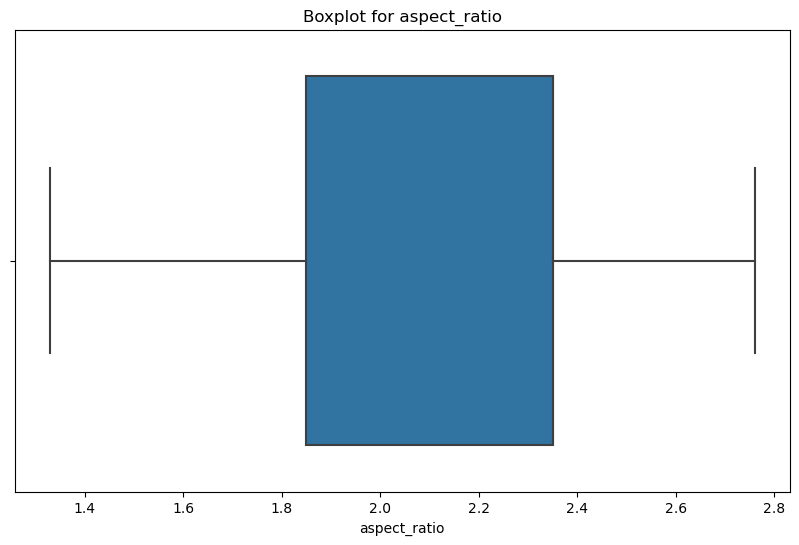

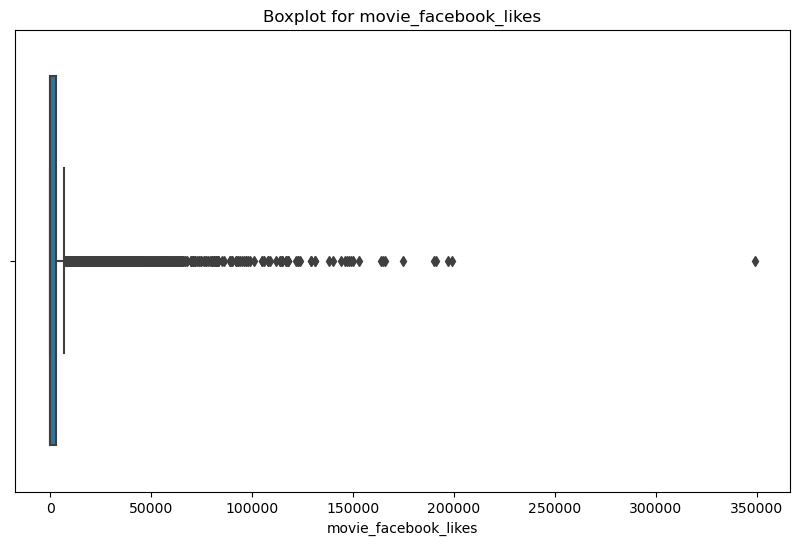

In [389]:
#use box plot to see features outliers
for column in numeric_data:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f"Boxplot for {column}")
    plt.show()

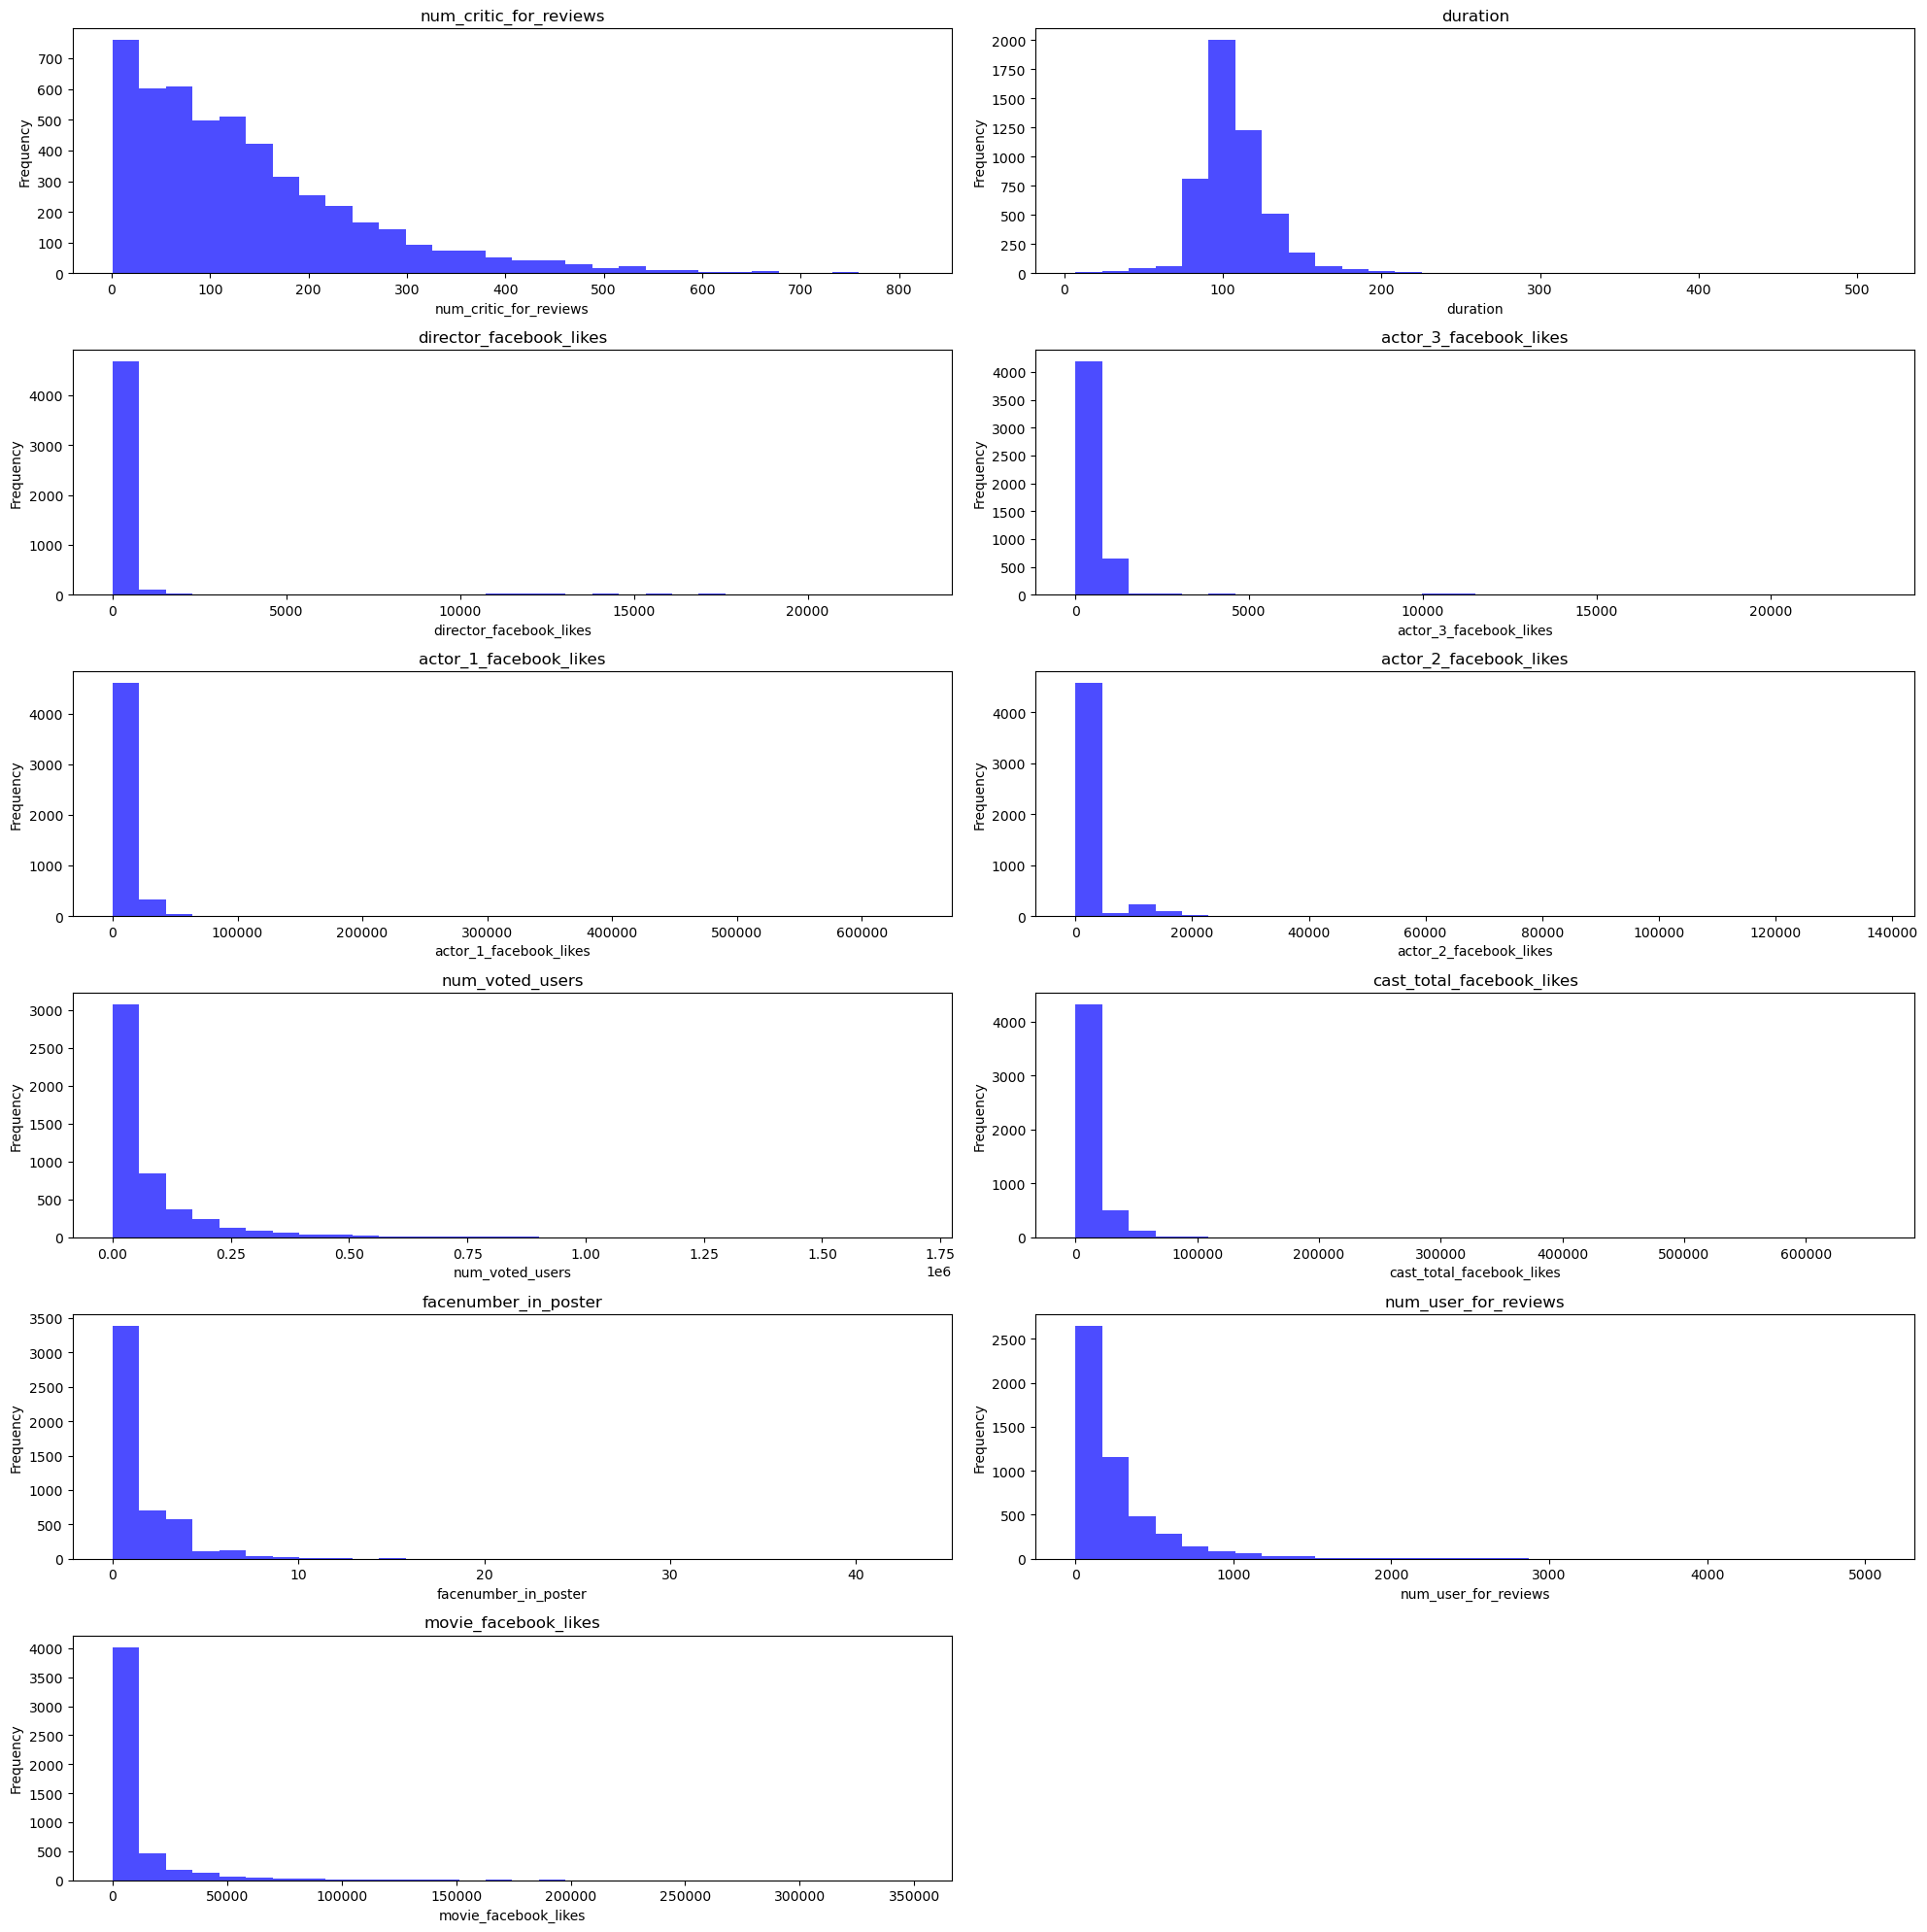

In [390]:
#see feature distribution
genuine_numeric_cols = ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
                        'actor_3_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                        'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 
                        'num_user_for_reviews', 'movie_facebook_likes']

plot_rows = 6
plot_cols = 2

fig, ax = plt.subplots(nrows=plot_rows, ncols=plot_cols, figsize=(20, 20))

col_index = 0

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        if col_index < len(genuine_numeric_cols):
            column_name = genuine_numeric_cols[col_index]
            ax[row_count][col_count].hist(data[column_name].dropna(), bins=30, alpha=0.7, color='blue')
            ax[row_count][col_count].set_title(column_name)
            ax[row_count][col_count].set_xlabel(column_name)
            ax[row_count][col_count].set_ylabel('Frequency')
            col_index += 1
        else:
            ax[row_count][col_count].axis('off')

plt.tight_layout()
plt.show()

## handle outliers

In [391]:
# 1. Handle Outliers
def handle_outliers(df, columns, factor=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

outlier_columns = ['budget', 'gross', 'num_critic_for_reviews','duration','director_facebook_likes','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','genres','num_voted_users','cast_total_facebook_likes','facenumber_in_poster','num_user_for_reviews','movie_facebook_likes'] 
data = handle_outliers(data, outlier_columns)

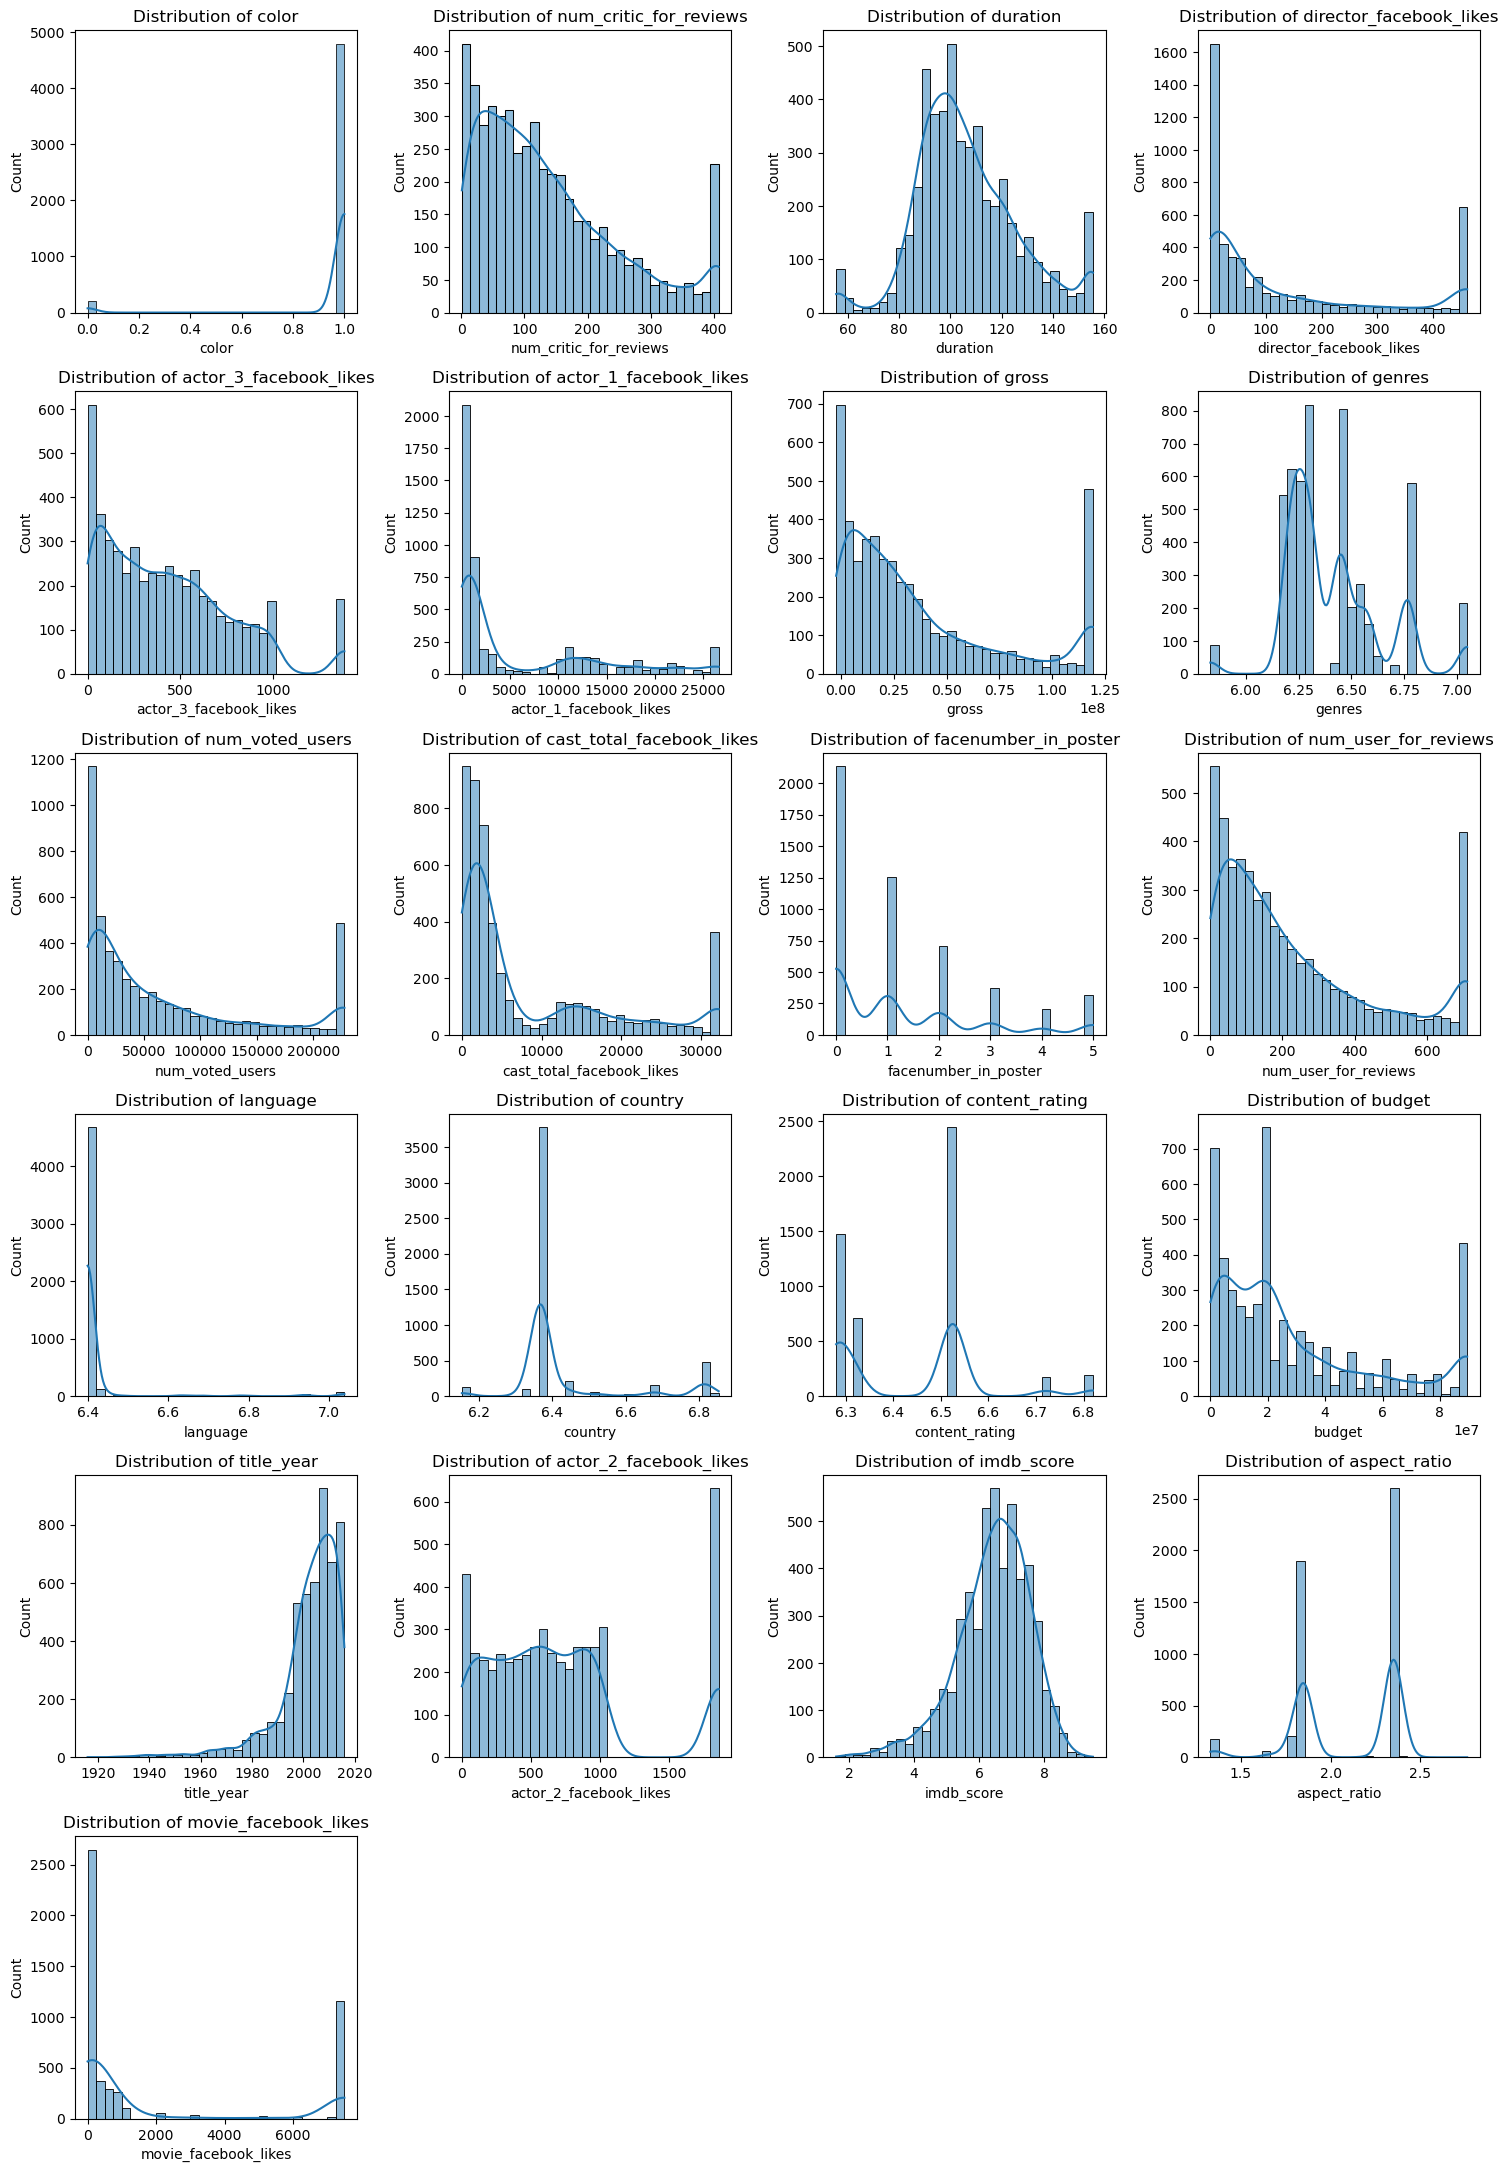

In [392]:
#see distribution
plt.figure(figsize=(15, 25))

for i, column in enumerate(data):
    plt.subplot(7, 4, i+1)  
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()

## handle skewness

In [393]:
def reduce_skewness(df, columns):
    for col in columns:
        if df[col].skew() > 1:
            df[col] = np.log1p(df[col])  
    return df
  
skewed_columns = ['budget', 'num_critic_for_reviews','director_facebook_likes','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','num_voted_users','cast_total_facebook_likes','facenumber_in_poster','num_user_for_reviews','movie_facebook_likes'] 

data = reduce_skewness(data, skewed_columns)

### Standardization

In [394]:
scaler = StandardScaler()  
normalized_data = scaler.fit_transform(data[outlier_columns + skewed_columns]) 
data[outlier_columns + skewed_columns] = normalized_data

## Categorization

In [395]:
def categorize_imdb(score):
    if score <= 2:
        return 'Poor'
    elif score <= 4:
        return 'Below Average'
    elif score <= 6:
        return 'Average'
    elif score <= 8:
        return 'Good'
    else:
        return 'Excellent'

data['imdb_category'] = data['imdb_score'].apply(categorize_imdb)
print(Counter(data['imdb_category']))
le = LabelEncoder()
data['imdb_category'] = le.fit_transform(data['imdb_category'])
data.drop(columns=['imdb_score'],inplace = True)

Counter({'Good': 3178, 'Average': 1398, 'Excellent': 250, 'Below Average': 165, 'Poor': 7})


# feature selection

## drop high correlation columns

In [396]:
X = data.drop(columns=['imdb_category'])
y = data['imdb_category']

corr_matrix = X.corr()

threshold = 0.8
to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

X = X.drop(columns=to_drop)

print(f"Removed {len(to_drop)} features with high correlation.")
print("Columns removed due to high correlation:", to_drop)

Removed 3 features with high correlation.
Columns removed due to high correlation: {'num_user_for_reviews', 'actor_2_facebook_likes', 'cast_total_facebook_likes'}


## drop low variability columns

In [397]:
# Select only the specified columns to check
columns_to_check = ['color', 'facenumber_in_poster', 'language', 'country', 'aspect_ratio']
X_subset = X[columns_to_check]

# Apply VarianceThreshold to the subset
threshold = 0.04
selector = VarianceThreshold(threshold)
selector.fit(X_subset)

# Identify low-variance columns
low_variance_columns = [col for col, var in zip(X_subset.columns, selector.variances_) if var < threshold]

# Print results
for col, var in zip(X_subset.columns, selector.variances_):
    print(f"Column: {col}, Variance: {var}")

if low_variance_columns:
    print("\nColumns with low variance (below threshold):", low_variance_columns)
else:
    print("\nNo columns with low variance (below threshold).")

X = X.drop(columns=low_variance_columns)

Column: color, Variance: 0.039701234635510875
Column: facenumber_in_poster, Variance: 1.0000000000000002
Column: language, Variance: 0.00929618416094612
Column: country, Variance: 0.022755361183574924
Column: aspect_ratio, Variance: 0.08362274137746334

Columns with low variance (below threshold): ['color', 'language', 'country']


In [398]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4998 entries, 0 to 5042
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_critic_for_reviews   4998 non-null   float64
 1   duration                 4998 non-null   float64
 2   director_facebook_likes  4998 non-null   float64
 3   actor_3_facebook_likes   4998 non-null   float64
 4   actor_1_facebook_likes   4998 non-null   float64
 5   gross                    4998 non-null   float64
 6   genres                   4998 non-null   float64
 7   num_voted_users          4998 non-null   float64
 8   facenumber_in_poster     4998 non-null   float64
 9   content_rating           4998 non-null   float64
 10  budget                   4998 non-null   float64
 11  title_year               4998 non-null   float64
 12  aspect_ratio             4998 non-null   float64
 13  movie_facebook_likes     4998 non-null   float64
dtypes: float64(14)
memory usage: 

## select k best

In [399]:
selector = SelectKBest(f_classif, k=13)  
selector.fit(X, y)

selected_columns = X.columns[selector.get_support()]

print("Top 13 Features:", selected_columns)
X_selected = X[selected_columns]

Top 13 Features: Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'facenumber_in_poster', 'content_rating', 'budget',
       'title_year', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')


# model training

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [401]:
#poor is extremely rare, so need to handle imbalance data
print("Training set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))

Training set class distribution: Counter({3: 2542, 0: 1118, 2: 200, 1: 132, 4: 6})
Test set class distribution: Counter({3: 636, 0: 280, 2: 50, 1: 33, 4: 1})


In [402]:
models = {
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced', 
        max_depth=None,  
        max_features='sqrt',
        min_samples_leaf=1,  
        min_samples_split=10, 
        n_estimators=200 
    ),
    "XGBoost": XGBClassifier(
        random_state=42,
        learning_rate=0.2, 
        max_delta_step=1, 
        max_depth=11, 
        n_estimators=100,  
        objective='binary:logistic', 
        subsample=0.6
    ),
    "SVM": SVC(
        random_state=42,
        C=115,
        class_weight=None,  
        decision_function_shape='ovr', 
        gamma=0.01,
        kernel='rbf',
        probability=True
    ),
}

Model: Random Forest
Cross-Validation (5-fold) Mean F1 Score: 0.7526
Test F1 Score: 0.7493
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       280
           1       0.77      0.30      0.43        33
           2       0.74      0.50      0.60        50
           3       0.80      0.86      0.83       636
           4       0.00      0.00      0.00         1

    accuracy                           0.76      1000
   macro avg       0.59      0.46      0.50      1000
weighted avg       0.75      0.76      0.75      1000



<Figure size 400x300 with 0 Axes>

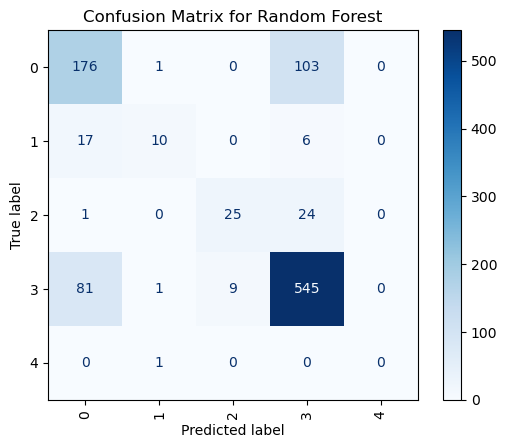

AUC-ROC Score: 0.8407


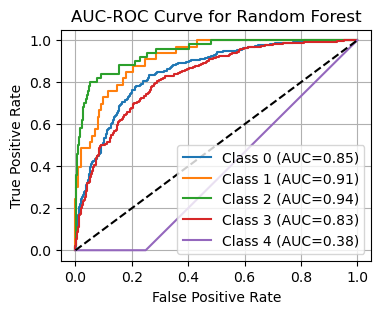

                    Feature  Importance
6           num_voted_users    0.161964
5                     gross    0.123841
0    num_critic_for_reviews    0.118644
1                  duration    0.092505
10               title_year    0.088581
4    actor_1_facebook_likes    0.086270
12     movie_facebook_likes    0.067651
9                    budget    0.062432
3    actor_3_facebook_likes    0.061986
2   director_facebook_likes    0.053590
8            content_rating    0.034795
7      facenumber_in_poster    0.024127
11             aspect_ratio    0.023614


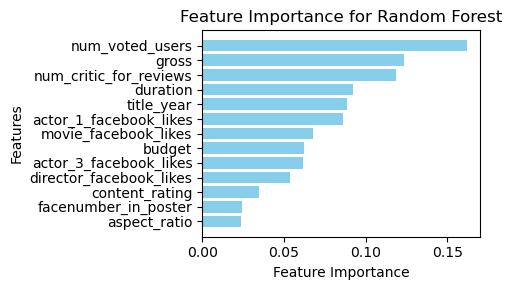

--------------------------------------------------
Model: XGBoost
Cross-Validation (5-fold) Mean F1 Score: 0.7601
Test F1 Score: 0.7528
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       280
           1       0.92      0.33      0.49        33
           2       0.78      0.50      0.61        50
           3       0.80      0.87      0.83       636
           4       0.00      0.00      0.00         1

    accuracy                           0.76      1000
   macro avg       0.63      0.46      0.51      1000
weighted avg       0.76      0.76      0.75      1000



<Figure size 400x300 with 0 Axes>

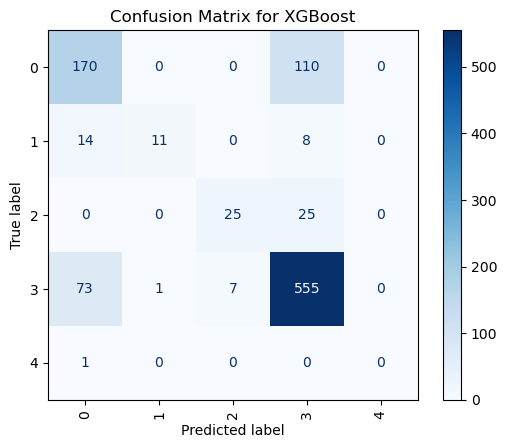

AUC-ROC Score: 0.8450


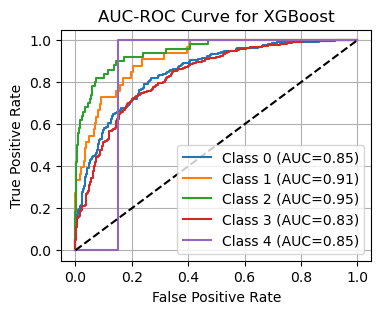

                    Feature  Importance
6           num_voted_users    0.132969
5                     gross    0.101108
10               title_year    0.084723
9                    budget    0.084636
1                  duration    0.084250
8            content_rating    0.075255
0    num_critic_for_reviews    0.069482
11             aspect_ratio    0.068477
12     movie_facebook_likes    0.067650
2   director_facebook_likes    0.062365
4    actor_1_facebook_likes    0.060075
3    actor_3_facebook_likes    0.058743
7      facenumber_in_poster    0.050268


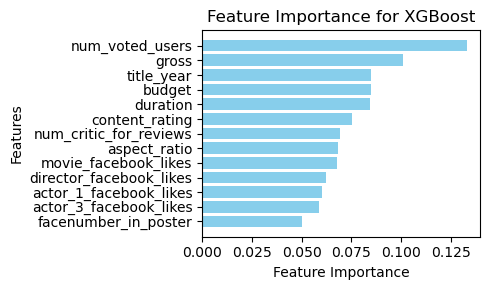

--------------------------------------------------
Model: SVM
Cross-Validation (5-fold) Mean F1 Score: 0.7004
Test F1 Score: 0.6875
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       280
           1       0.71      0.15      0.25        33
           2       0.67      0.40      0.50        50
           3       0.75      0.85      0.80       636
           4       0.00      0.00      0.00         1

    accuracy                           0.70      1000
   macro avg       0.54      0.38      0.41      1000
weighted avg       0.69      0.70      0.69      1000



<Figure size 400x300 with 0 Axes>

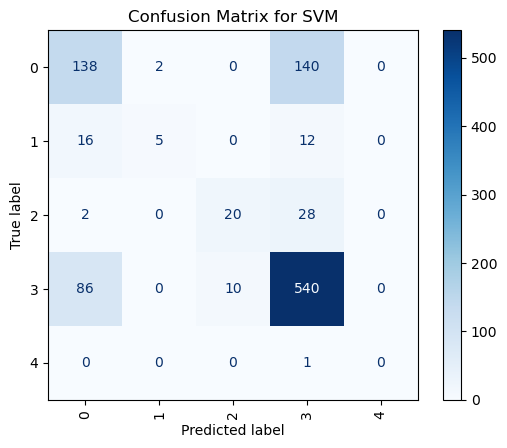

AUC-ROC Score: 0.7876


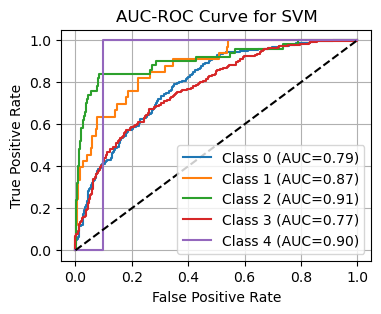

['facenumber_in_poster' 'aspect_ratio' 'content_rating'
 'actor_1_facebook_likes' 'director_facebook_likes'
 'actor_3_facebook_likes' 'movie_facebook_likes' 'budget' 'duration'
 'num_critic_for_reviews' 'gross' 'title_year' 'num_voted_users'] [-0.0032  0.001   0.0044  0.0114  0.0122  0.0158  0.0182  0.0354  0.0424
  0.0436  0.0622  0.0776  0.0974]


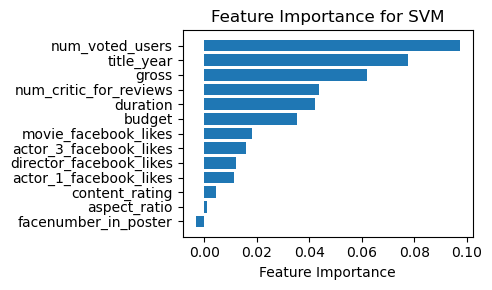

--------------------------------------------------


In [403]:
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # F1 Scores
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    cv_mean_score = cv_scores.mean()
    
    # Print performance metrics
    print(f"Model: {name}")
    print(f"Cross-Validation (5-fold) Mean F1 Score: {cv_mean_score:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Classification Report on Test Set:\n{classification_report(y_test, y_test_pred, zero_division=0)}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    plt.figure(figsize=(4, 3))
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    
    # AUC-ROC Curve and Score
    if hasattr(model, "predict_proba"):  
        y_test_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
        print(f"AUC-ROC Score: {roc_auc:.4f}")
        
        # Plot AUC-ROC curve
        plt.figure(figsize=(4, 3))
        for i in range(y_test_proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, i], pos_label=i)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc_score(y_test == i, y_test_proba[:, i]):.2f})')
            
        plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
        plt.title(f"AUC-ROC Curve for {name}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="best")
        plt.grid()
        plt.show()
    
    # Feature importance
    if name == 'SVM':
        perm_importance = permutation_importance(model, X_test, y_test)
        feature_names = selected_columns
        features = np.array(feature_names)
        sorted_idx = perm_importance.importances_mean.argsort()
        print(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.figure(figsize=(5, 3))
        plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance for {name}")
        plt.tight_layout()
        plt.show()
    else:
        if hasattr(model, "feature_importances_"):
            feature_importances = model.feature_importances_
            features_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': feature_importances
            })
            features_df = features_df.sort_values(by='Importance', ascending=False)
            print(features_df)
            
            plt.figure(figsize=(5, 3))
            plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
            plt.xlabel('Feature Importance')
            plt.ylabel('Features')
            plt.title(f"Feature Importance for {name}")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
    print("-" * 50)


# hyperparameter tuning

In [404]:
# Define the hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 500],  
        "max_depth": [None, 10, 20,30],  
        "min_samples_split": [2, 10],  
        "min_samples_leaf": [1, 2], 
        "class_weight": [None, 'balanced'],
        "max_features": ['sqrt', 'log2'],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200, 500], 
        "learning_rate": [0.001, 0.01, 0.1, 0.2], 
        "max_depth": [5, 9, 11, 13],  
        "subsample": [0.6, 0.8, 1.0], 
        "objective": ['binary:logistic', 'multi:softmax'], 
        "max_delta_step": [0, 1, 2], 
    },
    "SVM":{
        "C": [0.01, 0.1, 10, 100, 115], 
        "kernel": ['linear', 'rbf'],  
        "gamma": ['scale', 'auto', 0.01, 0.0, 10], 
        "class_weight": [None, 'balanced'],  
        "decision_function_shape": ['ovr', 'ovo'],  
    }
}

Optimizing Random Forest...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Hyperparameters for Random Forest: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation F1 Score for Random Forest: 0.7526
Test F1 Score: 0.7493
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       280
           1       0.77      0.30      0.43        33
           2       0.74      0.50      0.60        50
           3       0.80      0.86      0.83       636
           4       0.00      0.00      0.00         1

    accuracy                           0.76      1000
   macro avg       0.59      0.46      0.50      1000
weighted avg       0.75      0.76      0.75      1000



<Figure size 400x300 with 0 Axes>

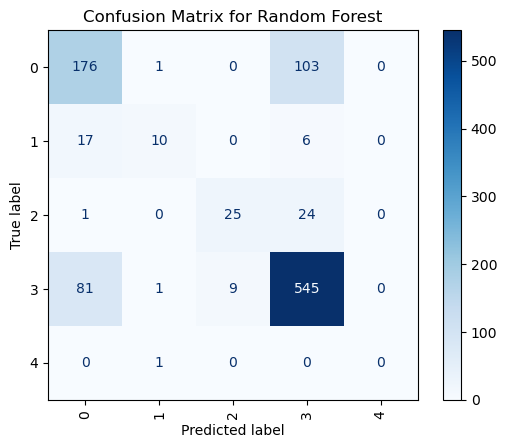

AUC-ROC Score: 0.8407


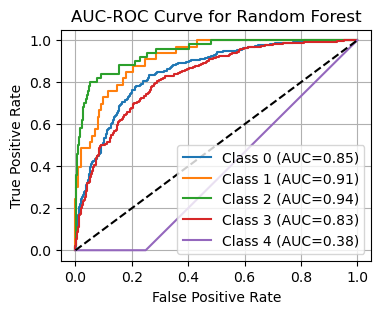

                    Feature  Importance
6           num_voted_users    0.161964
5                     gross    0.123841
0    num_critic_for_reviews    0.118644
1                  duration    0.092505
10               title_year    0.088581
4    actor_1_facebook_likes    0.086270
12     movie_facebook_likes    0.067651
9                    budget    0.062432
3    actor_3_facebook_likes    0.061986
2   director_facebook_likes    0.053590
8            content_rating    0.034795
7      facenumber_in_poster    0.024127
11             aspect_ratio    0.023614


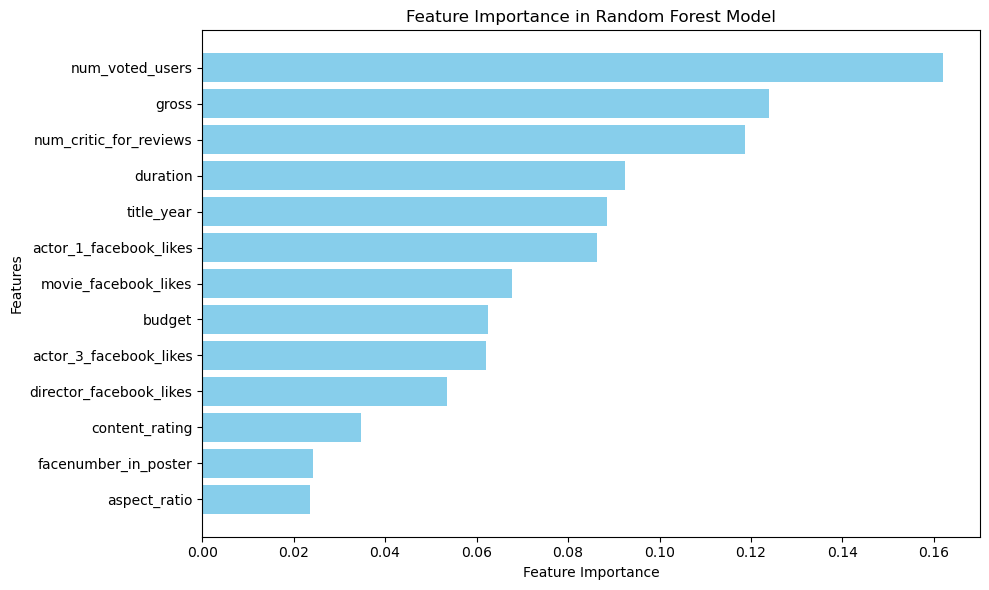

--------------------------------------------------
Optimizing XGBoost...
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Hyperparameters for XGBoost: {'learning_rate': 0.2, 'max_delta_step': 1, 'max_depth': 11, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 0.6}
Best Cross-Validation F1 Score for XGBoost: 0.7601
Test F1 Score: 0.7528
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       280
           1       0.92      0.33      0.49        33
           2       0.78      0.50      0.61        50
           3       0.80      0.87      0.83       636
           4       0.00      0.00      0.00         1

    accuracy                           0.76      1000
   macro avg       0.63      0.46      0.51      1000
weighted avg       0.76      0.76      0.75      1000



<Figure size 400x300 with 0 Axes>

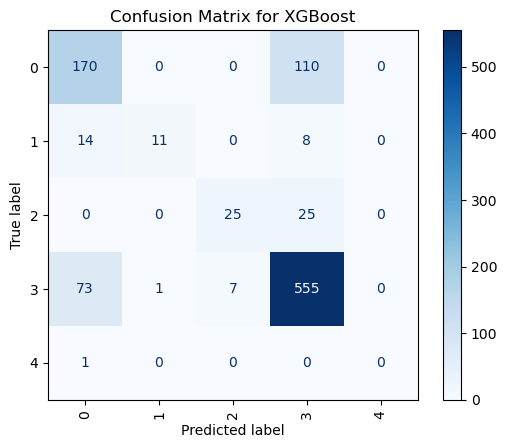

AUC-ROC Score: 0.8450


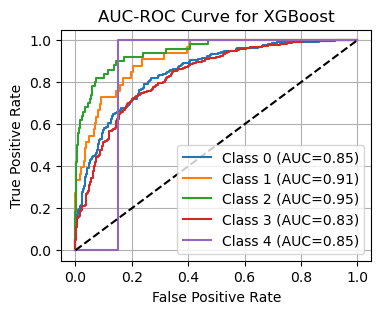

                    Feature  Importance
6           num_voted_users    0.132969
5                     gross    0.101108
10               title_year    0.084723
9                    budget    0.084636
1                  duration    0.084250
8            content_rating    0.075255
0    num_critic_for_reviews    0.069482
11             aspect_ratio    0.068477
12     movie_facebook_likes    0.067650
2   director_facebook_likes    0.062365
4    actor_1_facebook_likes    0.060075
3    actor_3_facebook_likes    0.058743
7      facenumber_in_poster    0.050268


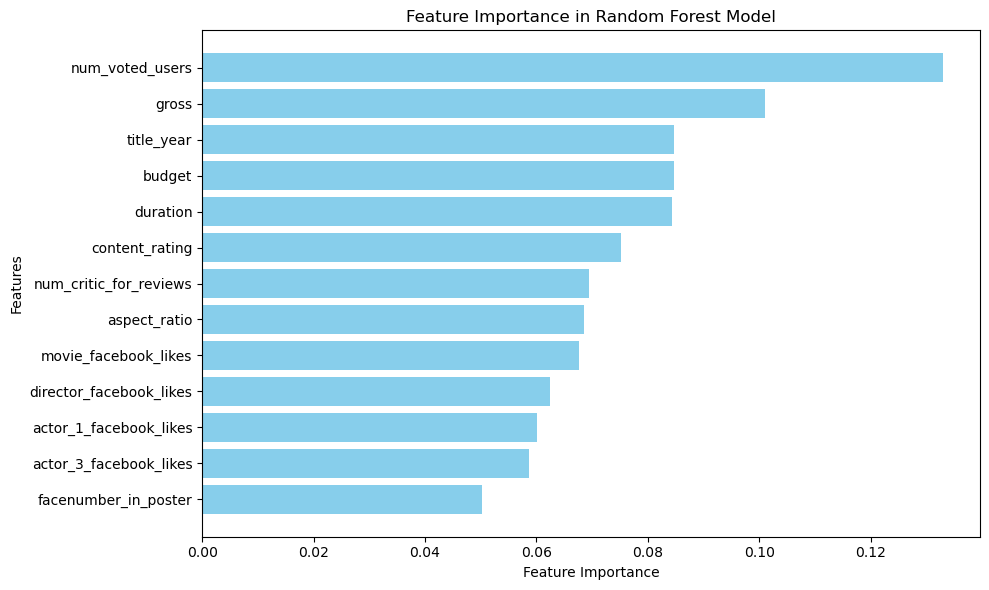

--------------------------------------------------
Optimizing SVM...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Hyperparameters for SVM: {'C': 115, 'class_weight': None, 'decision_function_shape': 'ovr', 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Validation F1 Score for SVM: 0.7004
Test F1 Score: 0.6875
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       280
           1       0.71      0.15      0.25        33
           2       0.67      0.40      0.50        50
           3       0.75      0.85      0.80       636
           4       0.00      0.00      0.00         1

    accuracy                           0.70      1000
   macro avg       0.54      0.38      0.41      1000
weighted avg       0.69      0.70      0.69      1000



<Figure size 400x300 with 0 Axes>

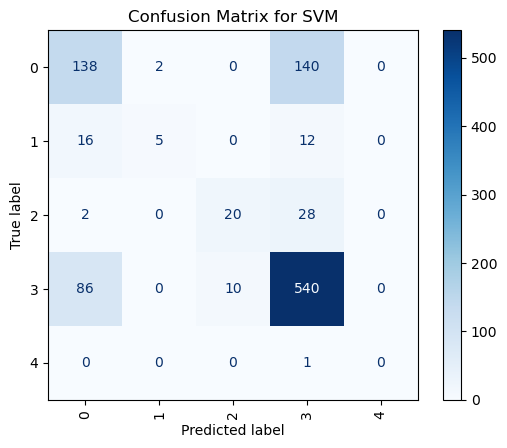

AUC-ROC Score: 0.7876


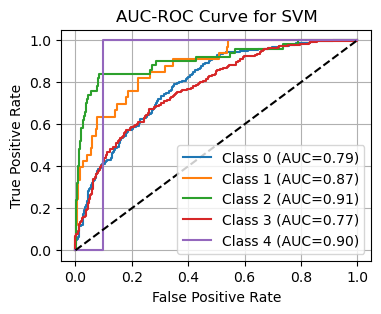

['content_rating' 'facenumber_in_poster' 'aspect_ratio'
 'actor_1_facebook_likes' 'director_facebook_likes'
 'actor_3_facebook_likes' 'movie_facebook_likes' 'budget'
 'num_critic_for_reviews' 'duration' 'gross' 'title_year'
 'num_voted_users'] [-0.0028 -0.0004  0.002   0.012   0.014   0.0142  0.0206  0.038   0.0404
  0.0426  0.0588  0.0704  0.1014]
--------------------------------------------------


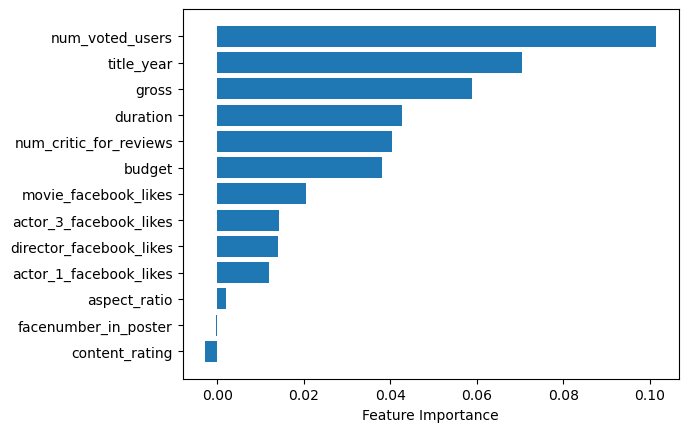

In [405]:
# Hyperparameter tuning using GridSearchCV
for name, model in models.items():
    print(f"Optimizing {name}...")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='f1_weighted', 
        cv=5, 
        verbose=1,
        n_jobs=-1 
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Best parameters and score
    print(f"Best Hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Best Cross-Validation F1 Score for {name}: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    
    y_test_pred = best_model.predict(X_test)
    
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Classification Report on Test Set:\n{classification_report(y_test, y_test_pred, zero_division=0)}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    plt.figure(figsize=(4, 3))
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    
    # AUC-ROC Curve and Score
    if hasattr(model, "predict_proba"):  
        y_test_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
        print(f"AUC-ROC Score: {roc_auc:.4f}")
        
        plt.figure(figsize=(4, 3))
        for i in range(y_test_proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, i], pos_label=i)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc_score(y_test == i, y_test_proba[:, i]):.2f})')
            
        plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
        plt.title(f"AUC-ROC Curve for {name}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="best")
        plt.grid()
        plt.show()
    
    if(name == 'SVM'):
        perm_importance = permutation_importance(model, X_test, y_test)

        feature_names = selected_columns
        features = np.array(feature_names)
        
        sorted_idx = perm_importance.importances_mean.argsort()
        print(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.xlabel("Feature Importance")
    else: 
        feature_importances = model.feature_importances_
        features_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importances
        })
        
        features_df = features_df.sort_values(by='Importance', ascending=False)
        print(features_df)
        
        plt.figure(figsize=(10, 6))
        plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Feature Importance in Random Forest Model')
        plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
        plt.tight_layout()
        plt.show()
    
    print("-" * 50)